In [2]:
import scipy
import xarray as xr
import grib2io
import pandas as pd
import datetime
from glob import glob
from tqdm.auto import tqdm
import numpy as np
from corner import quantile
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib
matplotlib.rcParams.update({
 "savefig.facecolor": "w",
 "figure.facecolor" : 'w',
 "figure.figsize" : (8,6),
 "text.color": "k",
 "legend.fontsize" : 20,
 "font.size" : 30,
 "axes.edgecolor": "k",
 "axes.labelcolor": "k",
 "axes.linewidth": 3,
 "xtick.color": "k",
 "ytick.color": "k",
 "xtick.labelsize" : 25,
 "ytick.labelsize" : 25,
 "ytick.major.size" : 12,
 "xtick.major.size" : 12,
 "ytick.major.width" : 2,
 "xtick.major.width" : 2,
 "font.family": 'STIXGeneral',
 "mathtext.fontset" : "cm"})
from PIL import Image
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from mpl_toolkits.basemap import Basemap
from pyproj import Proj
from metpy.units import units
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Data Assimilation

In the most general terms, data assimilation techniques attempt to combine theoretical models with observations (or really any two datasets) in the "best way possible" to improve both sets of data. This amounts to rectifying errors in both the forecast (magnitude, location and timing of event) and the necessarily sparse observations of the true system state: "for large scale systems, it is almost impossible to experimentally measure the full state of the system at a given time. For example, imagine simulating the atmospheric or oceanic flow, then you need to measure the velocity, temperature, density, etc. at every location corresponding to your numerical grid," (Ahmed+2020).

Data assimilation proceeds sequentially in time, applying a correction to the forecast based on a set of observed data and estimated errors that are present in both the observations and the forecast itself. The model organizes and propagates forward the information from previous observations. As new observations are added, that data is used to modify the model state to be as consistent as possible with them (i.e., data) *and* the previous information --> a sort of ouroboros of analysis and forecast.

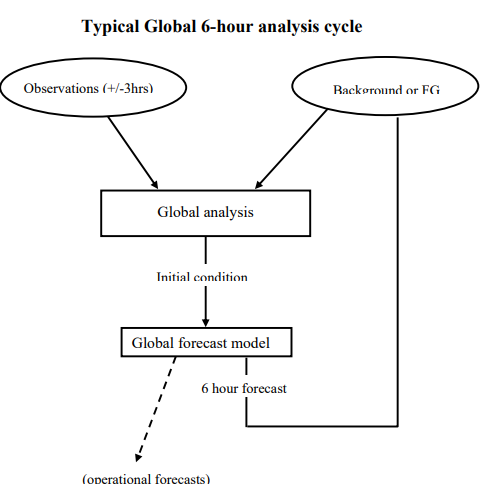


The very first step of the data assimilation cycle (which we don't see as it happens pre-blend) is the production of something like URMA -- taking irregularly spaced observations (both direct and indirect) of atmospheric state variables and estimating them onto a regular grid. Once gridded, these can be modified by the background field. And then applied to numerical models as a supplement for the ICs. 

As mentioned above, data assimilation amounts to a pre-process for NWPs but can also be used to combine predictions from several models + corrections from contemporaneous observations == the blend! BUT - correcting for the errors in the forecasts associated with both position and amplitude is difficult; "the standard measures of forecast skill, such as root-meansquare (r.m.s.) error and anomaly correlation all measure forecast error as the difference between a forecast and ananalysis at the same point in space and time. They are incapable of identifying a phase error as such. For example, a forecast of an intense, fast-moving feature can have a low skill score because of a small phase error that a human forecaster may consider minor. Hence, there is a need for an objective skill evaluation method that accounts for the presence of both phase and amplitude errors" (Nehrkorn+2003). 

Related is the treatment of probabilistic forecasts generated from ensembles of perturbed models. In the blend, there are ~17 models used to construct the value distributions for each variable (temp, precip, etc.). Some of these models are themselves made of an ensemble of models with different perturbation states (so in reality, 200+ realizations). In QM, each of these ensemble members would be mapped to the CDF constructed from the entire sample, but this can introduce issues originating from errors in the magnitude, timing, and location of weather events as predicted by the model. Furthermore, while QM (theoretically) provides really great probabilitic predictions for weather events, it's difficult to know how to communicate more deterministic estimates from an ensemble. 

An improvement we hope to make to the blend is to somehow efficiently combine the physically meaningful information encoded in the entire distribution of predictions from the ensemble. One way to do that is via coalescence, which seeks to quantify the uncertainity for coherent structures that can suffer multiple types of error in an ensemble of forecasts (as in above, it is necessary to correct for both phase and amplitude errors). "Consider, as an illustration, an ensemble of “one dimensional” fronts that contain position and amplitude errors, as shown in (the Figure below). If we were to ask what the mean front is, clearly the simplest solution is to take the mean of these fields, that is, calculate the mean vector. That would be terribly wrong, of course, because the mean simply does not look like any front in the ensemble. Coalescence instead calculates the mean amplitude field by marginalizing relative position errors. The method invokes an “N-body” type solution where each member in the ensemble gravitates to the others. In so doing, all of them discover a mean position where the amplitude mean is meaningful," (Ravela+2012)

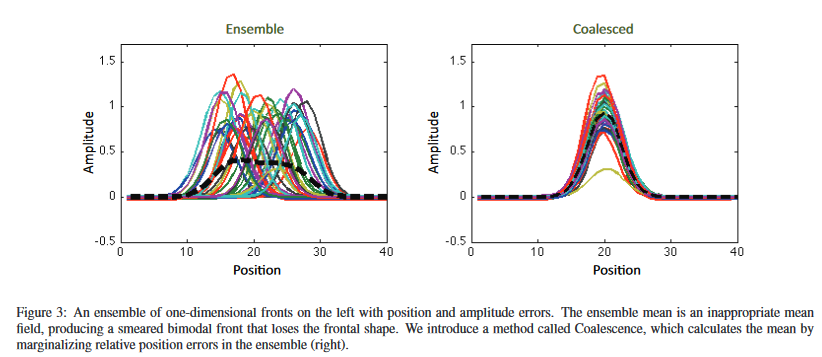

# Correcting Position and Amplitude Errors for NBM with Coalescence (Nehrkorn, Hamill, and Henderson, in prep.)

The corrrection and transformation of the distribution of forecasted features to deterministic products is nontrivial: "the raw ensemble mean is generally better than any single ensemble member in terms of mean squared errors, but predicted precipitation features are often unrealistic; because of differences in the position of precipitation features in the individual ensemble members, the ensemble mean areal extent is generally too large and the forecast extrema are too small. In addition, the ensemble mean product lacks fine-scale detail."

In the NBM, amplitude/additive corrections are made with the quantile mapping technique (see [the notebook on QMD in the Blend](https://github.com/SidneyLower-NOAA/mdl_smd_grib2io/blob/main/statistical_surveyor_of_sorts.ipynb)) but as of yet there is not a robust way to correct for position errors; the technique described in Nehrkorn, Hamill, and Henderson -- based on work by Nehrkorn, Auligne, and Hoffman 2014, Hoffman & Grassotti 1996, and Hoffman+1999 -- attempts to combine QM with coalescence in order to combine the information from the entire ensemble distribution (mindful of distribution variances which carry meaning).

## Feature Alignment Technique

Hoffman & Grassotti 1996 and Hoffman+1999, mentioned above, introduce a method for aligning forecast and observational data later called *Feature Calibration and Alignment* (FCA) by optimizing a set of vectors describing the spatial displacement and amplitude residuals between the two datasets. The alignment step is sometimes called *Feature Alignment Technique* (FAT) and can be used to align forecasts with observations or, like in coalescence, align ensemble members to arrive at a more physically meaningful ensemble mean. Below, I describe the feature alignment technique as outlined in Nehrkorn, Hamill, and Henderson (in prep) that aims to correct position errors between ensemble members before using QMD to correct amplitude errors between the ensemble and the analysis.

Determining a two-dimensional field of displacement vectors ($\delta$ **i**, $\delta$ **j**) that results in an improved agreement of a forecast **x** with available observations **y** is formulated as a nonlinear optimization of an objective function:

$$ J = J_r(\textbf{y}, H(\textbf{x}), \delta \textbf{i}, \delta \textbf{j}) + J_p (\delta \textbf{i}, \delta \textbf{j}) $$

where $J_r$ measures the residual errors of the adjusted field, $J_p$ is a penalty function that combines various constraints of the displacements, and $H$ is the observation operator that transform the forecast to observed variables. The displacements themselves are represented by a truncated double consine series, including only terms with a total wavenumber not exceeding some truncation wavenumber.

The residual error is calculated via 

$$ J_r = \sum_{n=1}^N {(y_n(i_n, j_n) - \textbf{x}(i_n + \delta \textbf{i}, j_n + \delta \textbf{j}))^2 \over \sigma_n^2} $$

over N observations. Importantly, FAT is versatile in that $y_n$ can be an analysis/observational dataset *or* something like the ensemble mean like in coalescence. The residual error just simply measures the mismatch between two datasets at the same location and time. 

The full penalty function is found by summing over the (weighted) individual penality functions that each constrain the displacements in a certain way:

$$ J_p = \lambda_a J_a + \lambda_d J_d + \lambda_m J_m + \lambda_{div} J_{div} $$

"The barrier function $J_a$, which is evaluated in gridpoint space, is designed such that displacements larger than a typical displacement scale Si are penalized heavily. In the smoothness constraint $J_d$, evaluated in spectral space as described in Hoffman and Grassotti (1996), roughness is measured by the mean square Laplacian of the scaled displacements, which penalizes higher wavenumbers selectively. The magnitude constraint $J_m$, evaluated in spectral space, measures the mean square magnitude of the displacements, which penalizes all wavenumbers equally, and serves to suppress displacements in data-void areas. Finally, the divergence constraint $J_{div}$, evaluated in gridpoint space, limits the amount of divergence in the displacement field."

The weights and free parameters that define each $J_p$ have been tuned from experiments comparing coalescned mean fields and selected ensemble member displacements.

### 1D Experiment: Aligning an Ensemble of Gaussian "Fronts"

As a simple demo, I will take the example ensemble from Ravela+2006 and align each member to the position of the ensemble mean, thereby arriving at a more physically meaningful mean front than that calculated from the un-aligned fronts.

In [10]:
def generate_ensemble_front(p,n=1,p0=20.,sigma0=2.):
    this_ens=[]
    xf_med = np.exp((-(p-p0).T * (p-p0))/(2*sigma0**2))
    for mem in range(n):
        a = np.random.normal(1,0.2,1)
        b = np.random.normal(0,0.01,1)
        p0 = np.random.normal(20, 3, 1)
        xf = np.exp((-(p-p0).T * (p-p0))/(2*sigma0**2))

        this_ens.append(xf)

    return this_ens
    

In [16]:
nodes = np.linspace(0,40,40)

In [17]:
fronts = generate_ensemble_front(nodes,n=40)

Text(0, 0.5, 'amplitude')

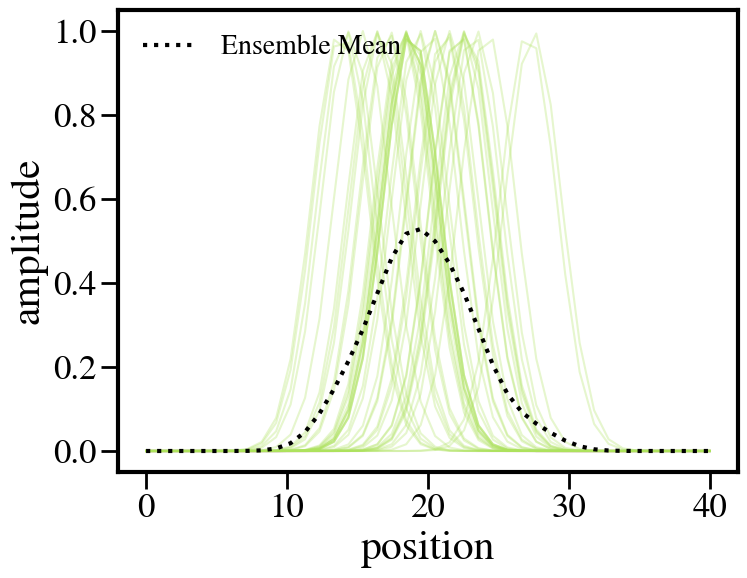

In [18]:
for i in range(40):
    plt.plot(nodes, fronts[i], color='#ADE25D', alpha=0.3)
plt.plot(nodes, np.mean(fronts, axis=0), color='black', ls=':', lw=3, label='Ensemble Mean')
plt.legend(frameon=False, loc='upper left')
plt.xlabel('position')
plt.ylabel('amplitude')

For a further simplification, I will define the cost function from just the residual error ($J_r$) and the barrier penalty ($J_a$) from above.

In [20]:
def residual_errors(delta, ens_data, ens_mean, ens_std, old_vec):

    #get ensemble at displaced grid points
    displaced_ens = np.interp(old_vec+delta, old_vec, ens_data)
    
    before_sum = (ens_mean - displaced_ens)**2
    return np.sum(before_sum / ens_std**2)

In [21]:
def displacement_penalty(disp_vec,S):
    return np.sum((disp_vec / S)**20)

In [22]:
def get_j(delta, ens_data, ens_mean, ens_std, S, old_vec):
    
    j_r = residual_errors(delta, ens_data, ens_mean, ens_std, old_vec)
    j_a = displacement_penalty(delta, S)

    return j_r + j_a
    

In [43]:
ens_std = np.std(fronts)
ens_mean = np.mean(fronts, axis=0)
S = 4.
delta0 = 1.

In [44]:
ens_displacement=[]
for i in range(40):
    minimize = scipy.optimize.minimize(get_j, delta0, args=(fronts[i], ens_mean, ens_std, S, nodes), 
                               method='BFGS')
    ens_displacement.append(minimize.x)

In [57]:
def remap_front(front, displaced_vec, remap_nodes):
    displaced_ens = np.interp(remap_nodes, displaced_vec, front)
    return displaced_ens
    

In [61]:
mean_coalesced_front = []
displaced_fronts = []
for i in range(40):
    displaced_fronts.append(remap_fronts(fronts[i], nodes - ens_displacement[i], nodes))
for i in range(40):
    mean_coalesced_front.append(np.mean([item[i] for item in displaced_fronts]))

Text(0, 0.5, 'amplitude')

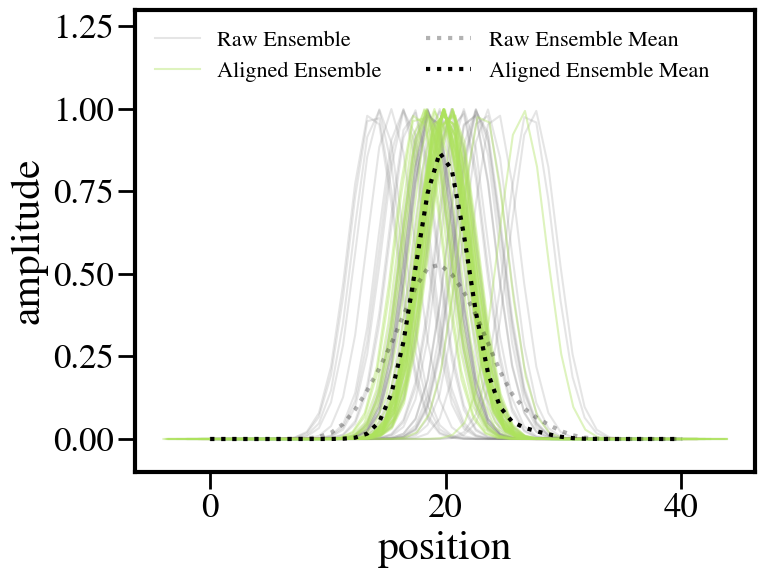

In [71]:
for i in range(40):
    if i == 1:
        plt.plot(nodes, fronts[i], color='gray', alpha=0.2, label='Raw Ensemble')
    else:
        plt.plot(nodes, fronts[i], color='gray', alpha=0.2)

for i in range(40):
    if i == 1:
        plt.plot(nodes - ens_displacement[i], fronts[i], color='#ADE25D', alpha=0.4, label='Aligned Ensemble')
    else:
        plt.plot(nodes - ens_displacement[i], fronts[i], color='#ADE25D', alpha=0.4)

plt.plot(nodes, np.mean(fronts, axis=0), color='black', ls=':', lw=3,alpha=0.3, label='Raw Ensemble Mean')
plt.plot(nodes, mean_coalesced_front,color='black', ls=':', lw=3,label='Aligned Ensemble Mean')
plt.legend(frameon=False, loc='upper left',ncol=2, fontsize=16)
plt.ylim([-0.1, 1.3])
plt.xlabel('position')
plt.ylabel('amplitude')

### 2D: FAT on GEFS Precipitation Forecasts

So how to apply to the NBM? Generalizing to 2D is not so hard in princple, but we need to be careful about managing computation costs: GEFS alone has 21 members with ~260,000 grid points which can be unruly to try and calculate displacement vectors for (even just horizonally). If alignment must be done on a finer grid (in anticipation of QMD calulcations with respect to URMA) the situation worsens. But for demonstration purposes, I have cut down the problem by only dealing with a slice of GEFS data (roughly encompassing CONUS but still just at native GEFS resolution).

In [18]:
###     A Brief Aside to Download GEFS Data from AWS 
# /scratch2/STI/mdl-sti/Sidney.Lower/test_data/gefs/get_gefs_data.py
#g = grib2io.open('/scratch2/STI/mdl-sti/Sidney.Lower/test_data/gefs/20210601/gefs01.t12z.f006')

In [3]:
#get GEFS members

adam_dat_dir = '/scratch2/STI/mdl-sti/Sidney.Lower/test_data/gefs/20210601/'
gefs_paths = sorted(glob(adam_dat_dir+'gefs*.t12z.f006'))
filters = dict(productDefinitionTemplateNumber=11)
gefs_data = xr.open_mfdataset(gefs_paths[1::2], chunks=None,engine='grib2io', filters=filters, 
                              parallel=False, concat_dim=[pd.Index(np.arange(len(gefs_paths)/2), name="member")],combine="nested")


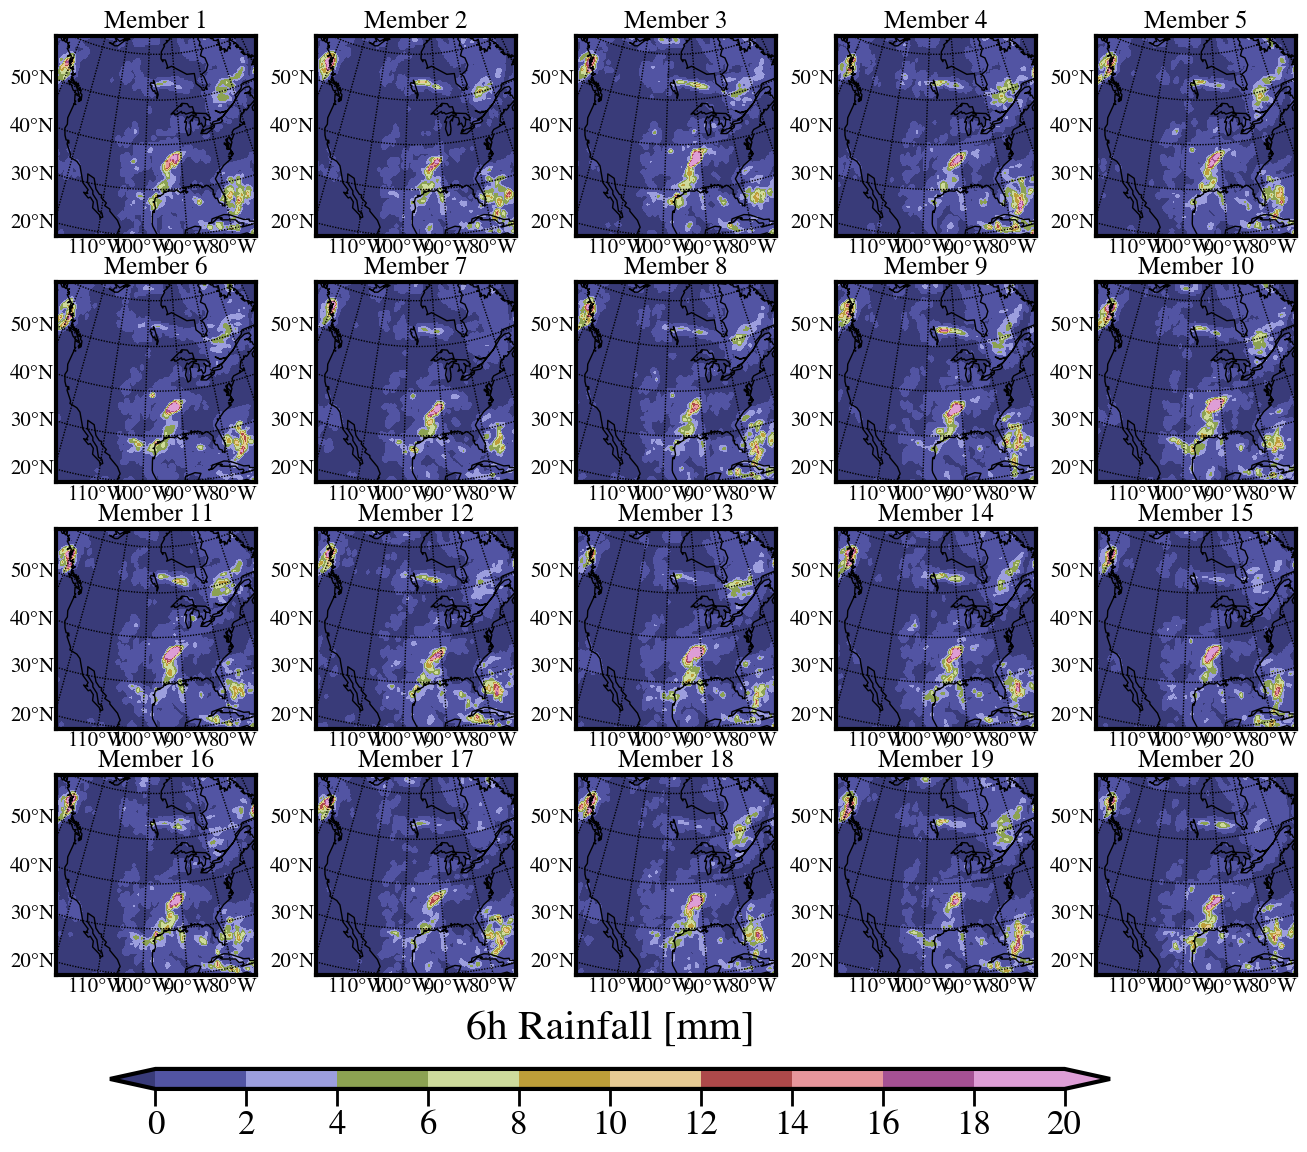

In [55]:
fig, axes = plt.subplots(4,5, figsize=(16,16))
temp_range = ticks=np.arange(0,22,2)
plt.subplots_adjust(wspace=0.3, hspace=-0.5)
lats, lons = gefs_data.latitude.data, gefs_data.longitude.data
m = Basemap(projection='lcc',lon_0=-97,lat_0=42,width=5e6,height=5e6,resolution='c')
xx, yy = m(lons, lats) #note to self, x=lons y=lats

for i in range(4):
    for j in range(5):
        mem = 5*i + j
        gefs_pcp = gefs_data.APCP.data[mem]
        cs = m.contourf(xx,yy,gefs_pcp,levels=temp_range,cmap=plt.cm.tab20b,extend='both',ax=axes[i,j])
        m.drawcoastlines(ax=axes[i,j])
        m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=15,ax=axes[i,j])
        m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=15,ax=axes[i,j])
        axes[i,j].set_title(f'Member {mem+1}', fontsize=18)

cbar_ax = inset_axes(axes[3,0],
                    width="500%",  # width = 50% of parent_bbox width
                    height="10%",  # height : 5%
                    loc='upper left',bbox_to_anchor=(0.2, -1.4, 1, 1),bbox_transform=axes[3,0].transAxes)

cbar=plt.colorbar(cs,orientation='horizontal', cax=cbar_ax,ticks=np.arange(0,22,2))
cbar.ax.set_xticklabels(['0','2','4', '6', '8', '10','12','14','16','18','20']) 
cbar.set_label('6h Rainfall [mm]', labelpad=-95)


For starters, we will need to generalize the residual function defined above to be able to interpolate on a 2D grid. scipy's Regular Grid Interpolator is able to interpolate data on a regular, rectilinear grid onto a set of points (that aren't necessarily a regular grid but for our purposes are). The idea is to construct the GEFS GRIB2 grid, input that into RegularGridInterpolator, then distort the grid and re-evaluate the precipitation on that distorted grid, represented by a list of points.

That step will take place only in the residual cost function $J_r$. The other components of the objective function deal with constraints on the displacements, as described above, penalizing large distortions ($J_a$) and ensuring the resulting distorted field is smooth ($J_d$). 

In [4]:
from scipy.interpolate import RegularGridInterpolator

#objective function
def get_j(ck_arr, b_ik, mean, obs_error, S,S_mag,interp_object,grid_points, m_k, n_k):
    c_k = {"x": ck_arr[:np.shape(b_ik)[1]], "y": ck_arr[np.shape(b_ik)[1]:]}
    j_r = residual_error(c_k, b_ik, mean,obs_error, interp_object,grid_points)
    j_a = barrier_func_gp(c_k, b_ik, S)
    j_d = smoothness_func_spec(c_k, m_k, n_k)
    j_div = divergence_func_gp(c_k, b_ik)
    j_m = magnitude_func_spec(c_k, S_mag)

    lambda_spec = np.shape(mean)[0]**2 / len(m_k)

    return np.log10(j_r + j_a + lambda_spec*j_d + lambda_spec*j_m + j_div)

def residual_error(c_k,b_ik,ens_mean,  obs_error, interp_object,grid_points):
    
    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])
    
    n_x_i = grid_points[:,0] + c_xi
    n_y_i = grid_points[:,1] + c_yi
    xy_grid = np.meshgrid(n_x_i,n_y_i, indexing='ij')
    displaced_grid = np.reshape(xy_grid, (2, -1), order='C').T
    displaced_precip = interp_object(displaced_grid)

    displaced_ens = np.zeros_like(ens_mean)
    for i in range(len(c_xi)):
        for j in range(len(c_yi)):
            point = len(c_yi)*i+j
            #print(point)
            displaced_ens[j, i] = displaced_precip[point]
    
    before_sum = (ens_mean - displaced_ens)**2
    return np.sum(before_sum / obs_error**2)

def barrier_func_gp(c_k, b_ik,S): #Ja
    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])
    return np.sum((c_xi / S)**20 +  (c_yi / S)**20)

def smoothness_func_spec(c_k, m_k, n_k): #Jd
    nu_k = (m_k**2 + n_k**2)**(2)
    scale = 0.5
    weight = 1.
    w_k={'x': (weight / scale**2) * nu_k,
            'y': (weight / scale**2) * nu_k}
    return np.sum(w_k['x'] * c_k['x']**2 + w_k['y'] * c_k['y']**2)

def divergence(field):
    "return the divergence of a n-D field"
    return np.sum(np.gradient(field),axis=0)

def divergence_func_gp(c_k, b_ik):

    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])
    nx, ny = len(c_xi), len(c_yi)

    dx = divergence(c_xi)
    dy = divergence(c_yi)
    return (dx+dy)**2

def magnitude_func_spec(c_k, S_mag):
    return np.sum((c_k['x']/S_mag)**2 + (c_k['y']/S_mag)**2)

One improvement (?) from the first example in 1D is the treatment / form the displacements take. In the first example, the displacements were physical -- we were finding the best set of displacements by evaluating the fit in grid space alone. Moving to 2D with more complicated coherent structures and larger parameter space necessitates a more sophisticated handling of the displacements. In Nehrkorn, Hamill, and Henderson (in prep), following Hoffman & Grassotti 1996, the displacements are represented by a truncated double consine series, and we are searching for the optimal coefficients for those basis functions:


$$ B_{k} = 2 \sin (m_k (ax + \frac{\pi}{2})) \sin(n_k (ay + \frac{\pi}{2}))$$

where $m_k$, $n_k$ are determined by the choice of truncation wavenumber and $k$ are the wavenumbers up to that truncation == degrees of freedom. This allows us to reduce the number of parameters to minimize from grid N lat x M longitude to ~10-20 thanks to the basis function truncation.

The displacements are then coefficients to these basis functions ($\Delta x, \Delta y$), with the distorted grid locations in physical/grid space found via

$$ x' = x + B\Delta x$$
$$ y' = y + B\Delta y$$

Below includes functions to calculate the set of basis functions by transforming the physical grid locations into Fourier space.

In [5]:
def basis_functions(target_x, target_y, m_k=None, n_k=None, xrange=(np.nan, np.nan), yrange=(np.nan, np.nan)):

    x = grid2fourier(target_x, xrange)
    y = grid2fourier(target_y, yrange)

    b_ik = np.zeros((len(x), len(m_k)))

    for k in range(len(m_k)):
        b_ik[:, k] = 2 * np.sin(m_k[k] * x) * np.sin(n_k[k] * y)

    return b_ik

def grid2fourier(x, xrange):
    return (np.pi / np.diff(xrange)) * (x - xrange[0])

def basis_truncation(n=3):
    m_k = np.repeat(np.arange(1, n + 1), n)
    n_k = np.repeat(np.arange(1, n + 1), np.repeat(n, n))
    select = m_k**2 + n_k**2 <= n**2

    return m_k[select], n_k[select]

Lastly, we can explicitly define the gradient to our objective function instead of relying on the minimization routine to calculate for us. 

In [111]:
###-----------------------###
#  Gradients
###-----------------------###

def get_gradient_j(ck_arr, b_ik, mean_subsection, obs_error, S,S_mag,interp_object,grid_points, m_k, n_k):
    lambda_a, lambda_d, lambda_m, lambda_div = [1,1,1,1]
    c_k = {"x": ck_arr[:np.shape(b_ik)[1]], "y": ck_arr[np.shape(b_ik)[1]:]}
    g_c_k = c_k
    #add residual 
    g_c_k = g_calc_j_r(c_k,b_ik,mean_subsection, obs_error, interp_object,grid_points,g_c_k)
    #add barrier
    g_c_k = g_calc_j_a(c_k, b_ik, lambda_a, S, g_c_k)
    #add smoothness
    g_c_k = g_calc_j_d(c_k, m_k, n_k, lambda_d, g_c_k)
    #add magnitude
    g_c_k = g_calc_j_m(lambda_m, S_mag, g_c_k)
    #add divergence
    g_c_k = g_calc_j_div(c_k, b_ik,grid_points,lambda_div,g_c_k)

    #get back to array
    g_c_k_array = np.ravel(np.array([g_c_k['x'], g_c_k['y']])) 

    return g_c_k_array

# Assuming f is a NumPy array
def g_bilinear(ix, iy, f, dx_n, dy_n, gxy):
    """
    Adjoint of bilinear interpolate in the unit box.
    """
    f00 = f[ix, iy]
    f10 = f[ix + 1, iy]
    f01 = f[ix, iy + 1]
    f11 = f[ix + 1, iy + 1]

    gxy['x'] *= (-f00 * (1 - dy_n) + f10 * (1 - dy_n) - f01 * dy_n + f11 * dy_n)
    gxy['y'] *= (-f00 * (1 - dx_n) - f10 * dx_n + f01 * (1 - dx_n) + f11 * dx_n)
    return gxy


def g_calc_j_r(c_k,b_ik,ens_mean, obs_error, interp_object,grid_points,g_c_k):

    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])

    n_x_i = grid_points[:,0] + c_xi
    n_y_i = grid_points[:,1] + c_yi
    xy_grid = np.meshgrid(n_x_i,n_y_i, indexing='ij')
    displaced_grid = np.reshape(xy_grid, (2, -1), order='C').T
    displaced_precip = interp_object(displaced_grid)

    displaced_ens = np.ones_like(ens_mean)
    #print(np.shape(displaced_ens))
    for i in range(len(c_xi)):
        for j in range(len(c_yi)):
            point = len(c_yi)*i+j
            displaced_ens[j, i] = displaced_precip[point]
    
    g_x_dist = 2 * (1./obs_error) * (displaced_ens - ens_mean)
    x=grid_points[:,0]
    y=grid_points[:,1]
    dx,dy=0.5,0.5
    ix = x // dx + 1
    dx_n = (x % dx) / dx
    iy = y // dy + 1
    dy_n = (y % dy) / dy

    print(ix, iy)
    g_c_i = {}
    #gradient_of_displaced = np.gradient(displaced_ens)
    g_c_i['x'] = g_x_dist# * gradient_of_displaced[0]
    g_c_i['y'] = g_x_dist# * gradient_of_displaced[1]

    g_c_i = g_bilinear(ix, iy, displaced_ens, dx_n, dy_n, g_c_i)

    #g_c_k['x'] += np.sum((np.dot(np.transpose(b_ik), g_c_i['x'])),axis=1)
    #g_c_k['y'] += np.sum((np.dot(np.transpose(b_ik), g_c_i['y'])),axis=1)


    return g_c_i

def g_calc_j_d(c_k, m_k, n_k, lambda_d, g_c_k):

    nu_k = (m_k**2 + n_k**2)**(2)
    scale = 0.5
    weight = 1.
    w_k={'x': (weight / scale**2) * nu_k,
            'y': (weight / scale**2) * nu_k}
    
    g_c_k['x'] += lambda_d * 2 * w_k['x'] * c_k['x']
    g_c_k['y'] += lambda_d * 2 * w_k['y'] * c_k['y']
    return g_c_k

def g_calc_j_a(c_k, b_ik, lambda_a, S_a, g_c_k):
    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])
    c_i = {"x": c_xi, "y": c_yi}
    g_c_i = c_i
    g_c_i['x'] += (lambda_a * 20) / (S_a) * (g_c_i['x'] / (S_a)) ** (19)
    g_c_i['y'] += (lambda_a * 20) / (S_a) * (g_c_i['y'] / (S_a)) ** (19)

    g_c_k['x'] += np.dot(np.transpose(b_ik), g_c_i['x'])
    g_c_k['y'] += np.dot(np.transpose(b_ik), g_c_i['y'])

    return g_c_k

def g_calc_j_m(lambda_m, S_mag, g_c_k):

    g_c_k['x'] += (lambda_m * 2) / (S_mag) * (g_c_k['x'] / (S_mag))
    g_c_k['y'] += (lambda_m * 2) / (S_mag) * (g_c_k['y'] / (S_mag))
    return g_c_k

def g_calc_j_div(c_k, b_ik,grid_points,lambda_div,g_c_k):

    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])
    
    n_x_i = grid_points[:,0] + c_xi
    n_y_i = grid_points[:,1] + c_yi
    xy_grid = np.meshgrid(c_xi,c_yi, indexing='ij')
    #displaced_grid = np.reshape(xy_grid, (2, -1), order='C').T
    #displaced_precip = interp_object(displaced_grid)
    nx, ny = len(n_x_i), len(n_y_i)
    
    # Update g.gp.c.i$x
    gp_c_i_x = xy_grid[0]
    gp_c_i_y = xy_grid[1]
    
    # Update middle elements
    gp_c_i_x[2:nx-1, 1:ny-2] += lambda_div * (
        gp_c_i_x[2:nx-1, 1:ny-2] - gp_c_i_x[0:nx-3, 1:ny-2] +
        gp_c_i_y[1:nx-2, 2:ny-1] - gp_c_i_y[1:nx-2, 0:ny-3]
    )
    # Update left edge elements
    gp_c_i_x[0:nx-3, 1:ny-2] -= lambda_div * (
        gp_c_i_x[2:nx-1, 1:ny-2] - gp_c_i_x[0:nx-3, 1:ny-2] +
        gp_c_i_y[1:nx-2, 2:ny-1] - gp_c_i_y[1:nx-2, 0:ny-3]
    )
    # Update top edge elements
    gp_c_i_y[1:nx-2, 2:ny-1] += lambda_div * (
        gp_c_i_x[2:nx-1, 1:ny-2] - gp_c_i_x[0:nx-3, 1:ny-2] +
        gp_c_i_y[1:nx-2, 2:ny-1] - gp_c_i_y[1:nx-2, 0:ny-3]
    )
    # Update bottom edge elements
    gp_c_i_y[1:nx-2, 0:ny-3] -= lambda_div * (
        gp_c_i_x[2:nx-1, 1:ny-2] - gp_c_i_x[0:nx-3, 1:ny-2] +
        gp_c_i_y[1:nx-2, 2:ny-1] - gp_c_i_y[1:nx-2, 0:ny-3]
    )
    g_gpc_i = {'x': gp_c_i_x, 'y': gp_c_i_y}
    for x in ['x', 'y']:
        g_gpc_i[x] = np.ravel(g_gpc_i[x])
    g_c_k['x'] += np.sum((np.dot(np.transpose(b_ik), g_c_i['x'])),axis=1)
    g_c_k['y'] += np.sum((np.dot(np.transpose(b_ik), g_c_i['y'])),axis=1)

    return g_c_k

In [ ]:
##------------------------------------##
#        Testing
##------------------------------------##

ens_mean = gefs_data.APCP.mean(dim='member')
raw_mean = ens_mean.data.compute()
ens_members = gefs_data.APCP.data.compute()
ens_std = gefs_data.APCP.std(dim='member').data.compute()

min_lon = 240 
max_lon = 601
min_lat = 0
max_lat = 361

y = gefs_data.latitude.data.compute().T[0][min_lat:max_lat]
x = gefs_data.longitude.data[0].compute()[min_lon:max_lon]
mem=9
ens_mem = ens_members[mem,min_lat:max_lat,min_lon:max_lon].T

#setup displacements
m_k, n_k = basis_truncation(5)
#get displacement basis functions, transforms grid x,y to fourier space
b_ik = basis_functions(x, y, m_k, n_k, [x[0], x[-1]], [y[0], y[-1]]
    )
d_o_f = len(m_k)
c_k = {"x": np.repeat(1e-2, d_o_f), "y": np.repeat(1e-2, d_o_f)}
#sigh need to change c_k to array structure (in 1D!!) or else scipy.minimize will get mad
ck_arr = np.ravel(np.array([c_k['x'], c_k['y']])) 

#physical displacements
c_xi = np.dot(b_ik, c_k['x'])
c_yi = np.dot(b_ik, c_k['y'])

#setup list of grid points
#xy_grid = np.meshgrid(x,y, indexing='ij')
#xy_list = np.reshape(xy_grid, (2, -1), order='C').T
xy_list = np.reshape([x,y],  (2,-1),order='C').T
interp = RegularGridInterpolator((x,y), ens_mem,bounds_error=False, fill_value=None)

obs_error = 0.2
S = 1.
S_mag = 0.5

#test_g = get_gradient_j(ck_arr, b_ik, raw_mean[min_lat:max_lat,min_lon:max_lon].T, obs_error, S,S_mag,interp,xy_list, m_k, n_k,)

### Demo

One major note (and really a limitation) is that the objective functions expect a symmetrical grid, i.e. length of x == length of y. So we cut down the GEFS grid to be symmetrical (while also saving lots of computation time in this demo as a bonus!)

In [113]:
#get data
mem=0
min_lon = 460 #this box spans roughly 20-90 deg N and 130-60 deg W
max_lon = 600
min_lat = 0
max_lat = 140

conus_only = gefs_data.APCP.isel(y=slice(min_lat,max_lat), x=slice(min_lon,max_lon))
ens_mean = conus_only.mean(dim='member')#conus_only.APCP.mean(dim='member')
raw_mean = ens_mean.data.compute()
ens_mem = conus_only.data[mem].compute()

#setup displacements
m_k, n_k = basis_truncation(5)
y = conus_only.latitude.data.compute().T[0]
x = conus_only.longitude.data[0].compute()
#get displacement basis functions, transforms grid x,y to fourier space
b_ik = basis_functions(x, y, m_k, n_k, [x[0], x[-1]], [y[0], y[-1]]
    )
d_o_f = len(m_k)
c_k = {"x": np.repeat(0.05, d_o_f), "y": np.repeat(0.05, d_o_f)}
#sigh need to change c_k to array structure (in 1D!!) or else scipy.minimize will get mad
ck_arr = np.ravel(np.array([c_k['x'], c_k['y']])) 

#physical displacements
c_xi = np.dot(b_ik, c_k['x'])
c_yi = np.dot(b_ik, c_k['y'])

#setup list of grid points
#xy_grid = np.meshgrid(x,y, indexing='ij')
#xy_list = np.reshape(xy_grid, (2, -1), order='C').T
xy_list = np.reshape([x,y],  (2,-1),order='C').T
interp = RegularGridInterpolator((x,y), ens_mem,bounds_error=False, fill_value=None)

So here, we construct a grid from the lats/lons of the (subsample of the) GEFS grid. The regular grid interpolator will construct that grid and associate it with the ensemble mean. The c_k vectors represent the coefficients of the basis functions that optimially align the ensemble member to the mean, which will be applied to the grid points (xy_list) later given to interpolate.

Text(0.3, 0.9, 'Coefficients = 0.05')

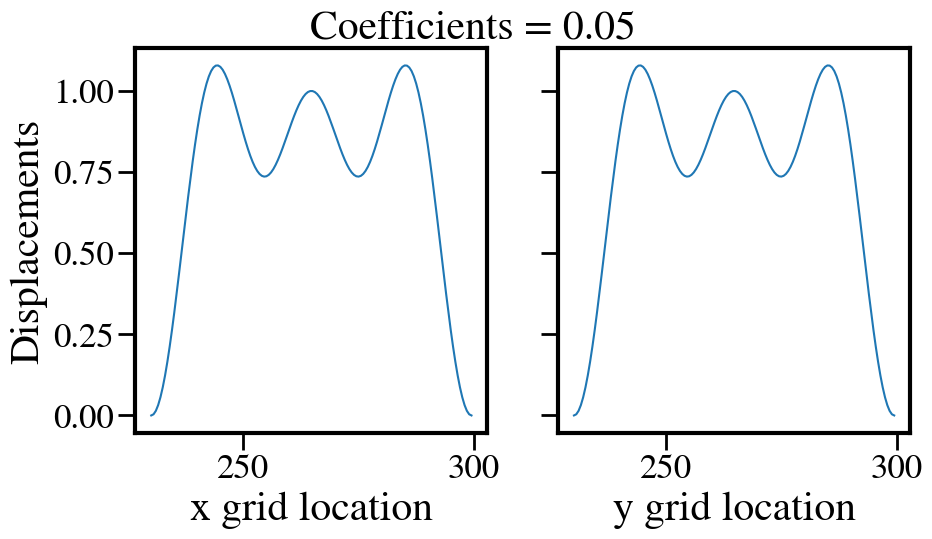

In [120]:
fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))

axes[0].plot(x, c_xi)
axes[1].plot(x, c_yi)
axes[0].set_ylabel('Displacements')
axes[0].set_xlabel('x grid location')
axes[1].set_xlabel('y grid location')
fig.text(s='Coefficients = 0.05', x=0.3,y=0.9)

In [123]:
#---------------------------------#
#
#     Minimize, test on 1 member
#
#---------------------------------#

std = 1.
S=4.
print('minimizing')
start = datetime.datetime.now()
minimize = scipy.optimize.minimize(get_j,ck_arr , args=(b_ik, conus_only.data[10].compute(), std, S,interp,xy_list, m_k, n_k), method='L-BFGS-B')
end = datetime.datetime.now()
print(end-start)

minimizing
0:00:07.309888


One thing I did not mention in the previous example is the method used to minimize the control variable. In Nehrkorn, Hamill, and Henderson (in prep.), the R source code used to optimize these displacements uses the nlminb function, an unconstrained and bounds-constrained quasi-Newton method optimizer based on a FORTRAN routine. In python, an equivalent method is scipy's L-BFGS-B, also a quasi-Newtonian bound-constrained minimization routine.

The output from minimizatioareis the displacement vect coefficientsor, which we can apply to the original conus-lite grid to arrive at the aligned precipitation field.

In [124]:
c_k_minimized = {"x": minimize.x[:np.shape(b_ik)[1]], "y": minimize.x[np.shape(b_ik)[1]:]}

c_xi = np.dot(b_ik, c_k_minimized['x'])
c_yi = np.dot(b_ik, c_k_minimized['y'])
n_x_i = x + c_xi
n_y_i = y + c_yi

xy_grid = np.meshgrid(n_x_i,n_y_i, indexing='ij')
displaced_grid = np.reshape(xy_grid, (2, -1), order='C').T
displaced_precip = interp(displaced_grid)

displaced_ens = np.ones_like(raw_mean)
#print(np.shape(displaced_grid))
for i in range(len(c_xi)):
    for j in range(len(c_yi)):
        point = len(c_yi)*i+j
        #print(point)
        displaced_ens[i,j] = displaced_precip[point]

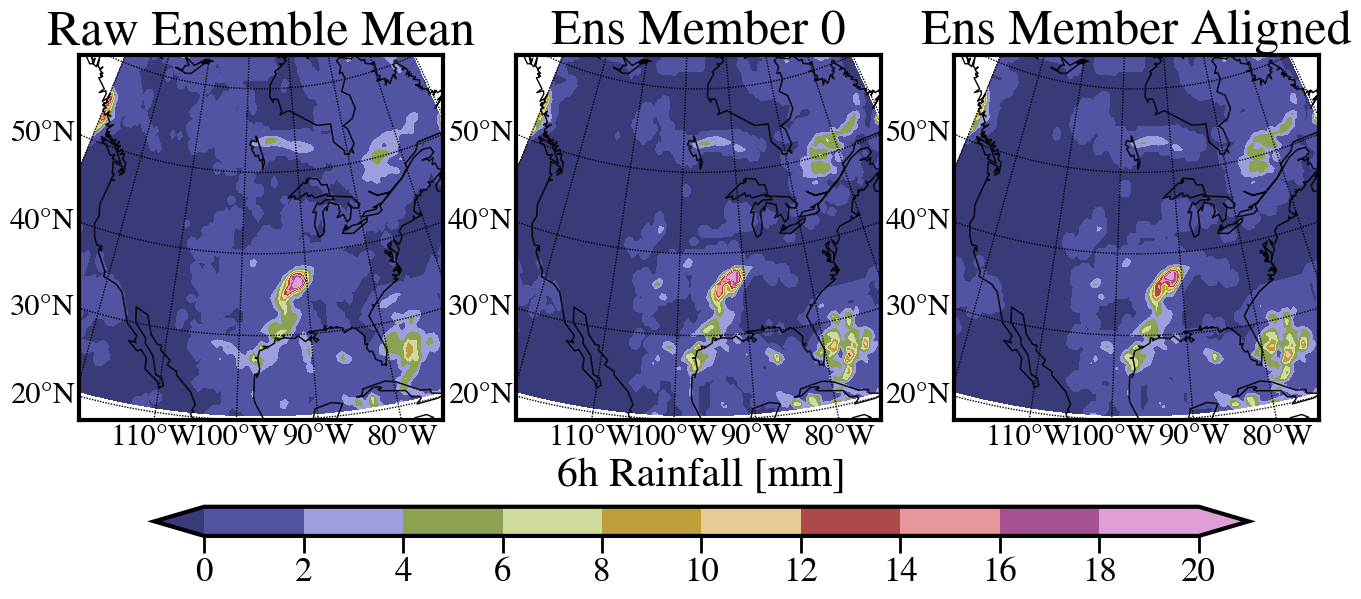

In [125]:
fig, axes = plt.subplots(1,3, figsize=(16,12), sharey=True)
temp_range = np.arange(0,22,2)

#GEFS
lats, lons = conus_only.latitude.data, conus_only.longitude.data
m = Basemap(projection='lcc',lon_0=-97,lat_0=42,width=5e6,height=5e6,resolution='c')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
cs = m.contourf(xx,yy,raw_mean,levels=temp_range,cmap=plt.cm.tab20b,extend='both',ax=axes[0])
axes[0].set_title('Raw Ensemble Mean')
cbar_ax = inset_axes(axes[0],
                    width="300%",  # width = 50% of parent_bbox width
                    height="8%",  # height : 5%
                    loc='upper left',bbox_to_anchor=(0.17, -1.2, 1, 1),bbox_transform=axes[0].transAxes)

cbar=plt.colorbar(cs,orientation='horizontal', cax=cbar_ax,ticks=np.arange(0,22,2))
cbar.ax.set_xticklabels(['0','2','4', '6', '8', '10','12','14','16','18','20']) 
cbar.set_label('6h Rainfall [mm]', labelpad=-95)

axes[1].set_title(f'Ens Member {mem}')
cs = m.contourf(xx,yy,ens_mem,levels=temp_range,cmap=plt.cm.tab20b,extend='both',ax=axes[1],)

axes[2].set_title(f'Ens Member Aligned')
cs = m.contourf(xx,yy,displaced_ens,levels=temp_range,cmap=plt.cm.tab20b,extend='both',ax=axes[2],)


for ax in range(3):
    m.drawcoastlines(ax=axes[ax])
    m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes[ax])
    m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes[ax])


## Demo: larger box, all members

In [6]:
#--------------------------------------#
#
#  Bigger Box
#
#--------------------------------------#
ens_mean = gefs_data.APCP.mean(dim='member')
raw_mean = ens_mean.data.compute()
ens_members = gefs_data.APCP.data.compute()
ens_std = gefs_data.APCP.std(dim='member').data.compute()

min_lon = 240 
max_lon = 601
min_lat = 0
max_lat = 361

In [7]:
#setup displacements
m_k, n_k = basis_truncation(5)
y = gefs_data.latitude.data.compute().T[0][min_lat:max_lat]
x = gefs_data.longitude.data[0].compute()[min_lon:max_lon]
#get displacement basis functions, transforms grid x,y to fourier space
b_ik = basis_functions(x, y, m_k, n_k, [x[0], x[-1]], [y[0], y[-1]])
d_o_f = len(m_k)
xy_list = np.reshape([x,y],  (2,-1),order='C').T

full_ens_stitched = np.zeros_like(ens_members)

c_kx_minimize, c_ky_minimize = [],[]

std = 1.3
S_a = 0.5
S_mag = 0.5

bounds = [[-1.,1.]]*np.shape(b_ik)[1]*2

for mem in tqdm(range(21)):
    ens_mem = ens_members[mem,min_lat:max_lat,min_lon:max_lon].T
    interp = RegularGridInterpolator((x,y), ens_mem,bounds_error=False, fill_value=None)
    c_k = {"x": np.repeat(0.1, d_o_f), "y": np.repeat(0.1, d_o_f)}
    ck_arr = np.ravel(np.array([c_k['x'], c_k['y']])) 
    minimize = scipy.optimize.minimize(fun=get_j,x0=ck_arr ,jac='2-point', 
                                       args=(b_ik, raw_mean[min_lat:max_lat,min_lon:max_lon].T, 
                                            std, S_a,S_mag,interp,xy_list, m_k, n_k), method='L-BFGS-B',bounds=bounds,
                                      options={'disp':True, 'iprint': 100,'maxfun': 15000, 'finite_diff_rel_step': 1.})
    c_k_minimized = {"x": minimize.x[:np.shape(b_ik)[1]], "y": minimize.x[np.shape(b_ik)[1]:]}
    c_xi = np.dot(b_ik, c_k_minimized['x'])
    c_yi = np.dot(b_ik, c_k_minimized['y'])
    n_x_i = x + c_xi
    n_y_i = y + c_yi
    
    xy_grid = np.meshgrid(n_x_i,n_y_i ,indexing='ij')
    displaced_grid = np.reshape(xy_grid, (2, -1), order='C').T
    displaced_precip = interp(displaced_grid)
    
    displaced_ens = np.zeros_like(raw_mean)
    for i in range(len(c_xi)):
        for j in range(len(c_yi)):
            point = len(c_yi)*i+j
            #print(point)
            displaced_ens[j+min_lat, i+min_lon] = displaced_precip[point]
            
    full_ens_stitched[mem,:,:] = displaced_ens

  0%|          | 0/21 [00:00<?, ?it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46936D+01    |proj g|=  1.10000D+00

At iterate    1    f=  5.84135D+00    |proj g|=  1.51181D-01

At iterate    2    f=  5.83799D+00    |proj g|=  9.77816D-02

At iterate    3    f=  5.83335D+00    |proj g|=  2.22987D-02

At iterate    4    f=  5.83283D+00    |proj g|=  1.68788D-02

At iterate    5    f=  5.83239D+00    |proj g|=  1.10765D-02

At iterate    6    f=  5.83235D+00    |proj g|=  9.03130D-03

At iterate    7    f=  5.83233D+00    |proj g|=  5.31993D-03

At iterate    8    f=  5.83233D+00    |proj g|=  5.31148D-03

At iterate    9    f=  5.83233D+00    |proj g|=  5.31143D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46936D+01    |proj g|=  1.10000D+00

At iterate    1    f=  5.77484D+00    |proj g|=  1.78485D-01

At iterate    2    f=  5.77183D+00    |proj g|=  8.95266D-02

At iterate    3    f=  5.76901D+00    |proj g|=  4.71375D-02

At iterate    4    f=  5.76782D+00    |proj g|=  2.11402D-02

At iterate    5    f=  5.76714D+00    |proj g|=  2.98379D-02

At iterate    6    f=  5.76695D+00    |proj g|=  1.06478D-02

At iterate    7    f=  5.76695D+00    |proj g|=  9.50625D-03

At iterate    8    f=  5.76693D+00    |proj g|=  4.37094D-03

At iterate    9    f=  5.76688D+00    |proj g|=  1.57493D-03

At iterate   10    f=  5.76686D+00    |proj g|=  4.95816D-04

At iterate   11    f=  5.76685D+00    |proj g|=  1.70115D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   12    f=  5.76685D+00    |proj g|=  7.23481D-05

At iterate   13    f=  5.76685D+00    |proj g|=  1.09094D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     13     46     43     0     0   1.091D-04   5.767D+00
  F =   5.7668518861905218     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46936D+01    |proj g|=  1.10000D+00

At iterate    1    f=  5.78553D+00    |proj g|=  1.78546D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   13    f=  5.77744D+00    |proj g|=  1.02938D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   14    f=  5.77744D+00    |proj g|=  9.50951D-05



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   15    f=  5.77744D+00    |proj g|=  9.50212D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     15     95     46     0     0   9.502D-05   5.777D+00
  F =   5.7774370992388073     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46936D+01    |proj g|=  1.10000D+00

At iterate    1    f=  5.82438D+00    |proj g|=  1.55499D-01

At iterate    2    f=  5.82157D+00    |proj g|=  9.53980D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   14    f=  5.81646D+00    |proj g|=  5.57129D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     14     30     43     0     0   5.571D-05   5.816D+00
  F =   5.8164584542428228     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46936D+01    |proj g|=  1.10000D+00

At iterate    1    f=  5.78169D+00    |proj g|=  1.79665D-01

At iterate    2    f=  5.77860D+00    |proj g|=  9.49722D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    8    f=  5.82648D+00    |proj g|=  1.02580D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30      8     40     37     0     0   1.026D-02   5.826D+00
  F =   5.8264832667055257     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46936D+01    |proj g|=  1.10000D+00

At iterate    1    f=  5.80446D+00    |proj g|=  1.67447D-01

At iterate    2    f=  5.80138D+00    |proj g|=  9.45159D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f=  5.79594D+00    |proj g|=  8.48731D-05

At iterate   16    f=  5.79594D+00    |proj g|=  6.16746D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     16     55     46     0     0   6.167D-05   5.796D+00
  F =   5.7959397176010121     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46936D+01    |proj g|=  1.10000D+00

At iterate    1    f=  5.82032D+00    |proj g|=  1.62343D-01

At iterate    2    f=  5.81726D+00    |proj g|=  9.44780D-02

At iterate    3    f=  5.81337D+00    |proj g|=  2.97145D-02

At iterate    4    f=  5.81257D+00    |proj g|=  1.96199D-02

At iterate    5    f=  5.81204D+00    |proj g|=  2.39557D-02

At iterate    6    f=  5.81195D+00    |proj g|=  1.13169D-02

At iterate    7    f=  5.81194D+00    |proj g|=  8.70942D-03

At iterate    8    f=  5.81194D+00    |proj g|=  6.53677D-03

At iterate    9    f=  5.81191D+00    |proj g|=  3.02591D-03

At iterate   10    f=  5.81188D+00    |proj g|=  1.64080D-03

At iterate   11    f=  5.81187D+00    |proj g|=  8.30479D-04

At iterate   12    f=  5.81186D+00    |proj g|=  1.14207D-04

At iterate   13    f=  5.8


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     16     66     46     1     0   1.222D-04   5.766D+00
  F =   5.7662605884699252     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46936D+01    |proj g|=  1.10000D+00

At iterate    1    f=  5.81191D+00    |proj g|=  1.63544D-01

At iterate    2    f=  5.80918D+00    |proj g|=  9.23683D-02

At iterate    3    f=  5.80595D+00    |proj g|=  3.33205D-02

At iterate    4    f=  5.80505D+00    |proj g|=  1.78214D-02

At iterate    5    f=  5.80456D+00    |proj g|=  2.31179D-02

At iterate    6    f=  5.80448D+00    |proj g|=  1.15509D-02

At iterate    7    f=  5.80446D+00    |proj g|=  9.41523D-03

At iterate    8    f=  5.80445D+00    |proj g|=  9.11537D-03

At iterate    9    f=  5.80438D+00    |proj g|=  5.99187D-03

At iterate   10    f=  5.80432D+00    |proj g|=  2.83177D-03

At iterate   11    f=  5.80431D+00    |proj g|=  1.09791D-03

At iterate   12    f=  5.80430D+00    |proj g|=  1.50055D-04

At iterate   13    f=  5.8


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46936D+01    |proj g|=  1.10000D+00

At iterate    1    f=  5.85527D+00    |proj g|=  1.41309D-01

At iterate    2    f=  5.85244D+00    |proj g|=  9.47025D-02

At iterate    3    f=  5.84837D+00    |proj g|=  2.17516D-02

At iterate    4    f=  5.84781D+00    |proj g|=  1.71588D-02

At iterate    5    f=  5.84743D+00    |proj g|=  9.05099D-03

At iterate    6    f=  5.84733D+00    |proj g|=  2.12716D-02

At iterate    7    f=  5.84732D+00    |proj g|=  1.38067D-02

At iterate    8    f=  5.84732D+00    |proj g|=  1.38060D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46936D+01    |proj g|=  1.10000D+00

At iterate    1    f=  5.79789D+00    |proj g|=  1.73732D-01

At iterate    2    f=  5.79478D+00    |proj g|=  9.14958D-02

At iterate    3    f=  5.79143D+00    |proj g|=  3.75358D-02

At iterate    4    f=  5.79045D+00    |proj g|=  1.96058D-02

At iterate    5    f=  5.78984D+00    |proj g|=  2.59544D-02

At iterate    6    f=  5.78969D+00    |proj g|=  1.07713D-02

At iterate    7    f=  5.78969D+00    |proj g|=  9.00117D-03

At iterate    8    f=  5.78969D+00    |proj g|=  5.82618D-03

At iterate    9    f=  5.78965D+00    |proj g|=  2.52473D-03

At iterate   10    f=  5.78962D+00    |proj g|=  1.08139D-03

At iterate   11    f=  5.78961D+00    |proj g|=  3.33154D-04

At iterate   12    f=  5.78961D+00    |proj g|=  1.31265D-04

At iterate   13    f=  5.7


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   14    f=  5.78961D+00    |proj g|=  4.55528D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     14     59     44     0     0   4.555D-05   5.790D+00
  F =   5.7896062115880174     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46936D+01    |proj g|=  1.10000D+00

At iterate    1    f=  5.80199D+00    |proj g|=  1.68442D-01

At iterate    2    f=  5.79876D+00    |proj g|=  9.08598D-02

At iterate    3    f=  5.79517D+00    |proj g|=  3.70484D-02

At iterate    4    f=  5.79413D+00    |proj g|=  2.13890D-02

At iterate    5    f=  5.79345D+00    |proj g|=  2.69461D-02

At iterate    6    f=  5.79329D+00    |proj g|=  1.10848D-02

At iterate    7    f=  5.79329D+00    |proj g|=  1.10830D-02
  ys=-2.655E-11  -gs= 1.760E-08 BFGS update SKIPPED

At iterate    8    f=  5.79329D+00    |proj g|=  1.10830D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of ac


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46936D+01    |proj g|=  1.10000D+00

At iterate    1    f=  5.78548D+00    |proj g|=  1.74798D-01

At iterate    2    f=  5.78242D+00    |proj g|=  9.23047D-02

At iterate    3    f=  5.77924D+00    |proj g|=  4.12169D-02

At iterate    4    f=  5.77816D+00    |proj g|=  2.05987D-02

At iterate    5    f=  5.77751D+00    |proj g|=  2.82535D-02

At iterate    6    f=  5.77733D+00    |proj g|=  1.20395D-02

At iterate    7    f=  5.77732D+00    |proj g|=  9.32238D-03

At iterate    8    f=  5.77730D+00    |proj g|=  7.07102D-03

At iterate    9    f=  5.77725D+00    |proj g|=  2.55001D-03

At iterate   10    f=  5.77722D+00    |proj g|=  1.31468D-03

At iterate   11    f=  5.77720D+00    |proj g|=  3.75783D-04

At iterate   12    f=  5.77720D+00    |proj g|=  8.53183D-05

At iterate   13    f=  5.7


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46936D+01    |proj g|=  1.10000D+00

At iterate    1    f=  5.81186D+00    |proj g|=  1.60918D-01

At iterate    2    f=  5.80898D+00    |proj g|=  9.44685D-02

At iterate    3    f=  5.80533D+00    |proj g|=  3.20114D-02

At iterate    4    f=  5.80450D+00    |proj g|=  1.95864D-02

At iterate    5    f=  5.80403D+00    |proj g|=  2.24567D-02

At iterate    6    f=  5.80397D+00    |proj g|=  1.19633D-02

At iterate    7    f=  5.80397D+00    |proj g|=  8.82017D-03

At iterate    8    f=  5.80396D+00    |proj g|=  8.82175D-03

At iterate    9    f=  5.80389D+00    |proj g|=  5.11292D-03

At iterate   10    f=  5.80385D+00    |proj g|=  2.73648D-03

At iterate   11    f=  5.80384D+00    |proj g|=  1.20992D-03

At iterate   12    f=  5.80383D+00    |proj g|=  2.11621D-04

At iterate   13    f=  5.8


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     14     58     44     0     0   1.572D-05   5.804D+00
  F =   5.8042494162997125     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46936D+01    |proj g|=  1.10000D+00

At iterate    1    f=  5.72014D+00    |proj g|=  2.23533D-01

At iterate    2    f=  5.71602D+00    |proj g|=  8.81141D-02

At iterate    3    f=  5.71393D+00    |proj g|=  6.01504D-02

At iterate    4    f=  5.71268D+00    |proj g|=  3.09444D-02

At iterate    5    f=  5.71162D+00    |proj g|=  1.34097D-02

At iterate    6    f=  5.71152D+00    |proj g|=  2.84737D-02

At iterate    7    f=  5.71146D+00    |proj g|=  7.61500D-03

At iterate    8    f=  5.71145D+00    |proj g|=  6.17006D-03

At iterate    9    f=  5.71142D+00    |proj g|=  6.61533D-03

At iterate   10    f=  5.71138D+00    |proj g|=  2.25557D-03

At iterate   11    f=  5.71137D+00    |proj g|=  4.20784D-04

At iterate   12    f=  5.71136D+00    |proj g|=  1.82587D-04

At iterate   13    f=  5.7


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f=  5.71136D+00    |proj g|=  1.40185D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   16    f=  5.71136D+00    |proj g|=  1.42329D-03
  ys=-6.452E-11  -gs= 2.257E-09 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     17    100     48     1     0   1.423D-03   5.711D+00
  F =   5.7113590548571089     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46936D+01    |proj g|=  1.10000D+00

At iterate    1    f=  5.80398D+00    |proj g|=  1.70459D-01

At iterate    2    f=  5.80061D+00    |proj g|=  9.49625D-02

At iterate    3    f=  5.79677D+00    |proj g|=  3.00905D-02

At iterate    4    f=  5.79590D+00    |proj g|=  2.04271D-02

At iterate    5    f=  5.79526D+00    |proj g|=  2.29245D-02

At iterate    6    f=  5.79510D+00    |proj g|=  1.11510D-02

At iterate    7    f=  5.79510D+00    |proj g|=  1.02526D-02

At iterate    8    f=  5.79508D+00    |proj g|=  6.99209D-03

At iterate    9    f=  5.79508D+00    |proj g|=  2.13383D-03

At iterate   10    f=  5.79506D+00    |proj g|=  1.15224D-03

At iterate   11    f=  5.79504D+00    |proj g|=  1.54091D-04

At iterate   12    f=  5.79504D+00    |proj g|=  1.65060D-05

At iterate   13    f=  5.7

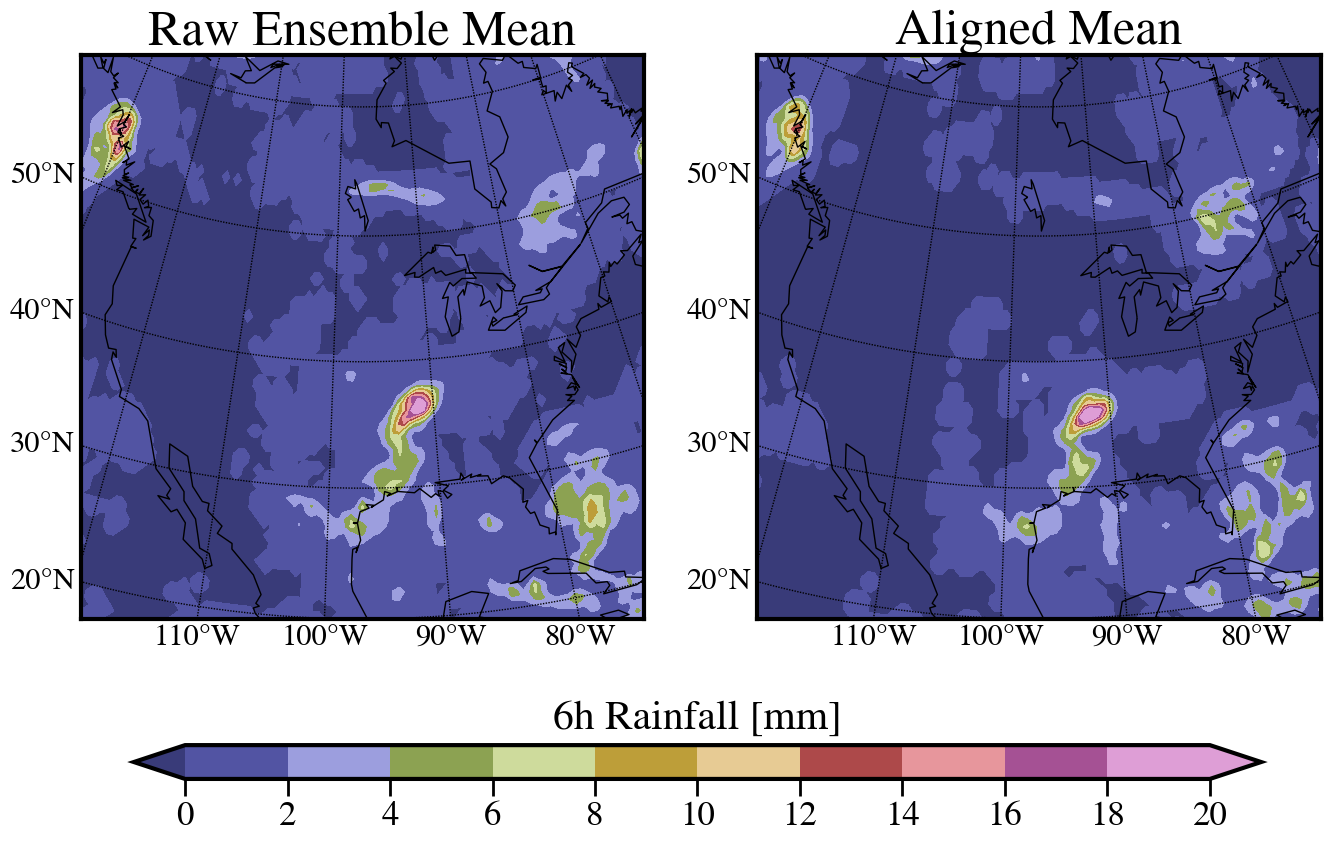

In [8]:
fig, axes = plt.subplots(1,2, figsize=(16,12), sharey=True)
temp_range = np.arange(0,22,2)

#GEFS
lats, lons = gefs_data.latitude.data, gefs_data.longitude.data
m = Basemap(projection='lcc',lon_0=-97,lat_0=42,width=5e6,height=5e6,resolution='c')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
cs = m.contourf(xx,yy,raw_mean,levels=temp_range,cmap=plt.cm.tab20b,extend='both',ax=axes[0])
axes[0].set_title('Raw Ensemble Mean')
cbar_ax = inset_axes(axes[0],
                    width="200%",  # width = 50% of parent_bbox width
                    height="6%",  # height : 5%
                    loc='upper left',bbox_to_anchor=(0.07, -1.2, 1, 1),bbox_transform=axes[0].transAxes)

cbar=plt.colorbar(cs,orientation='horizontal', cax=cbar_ax,ticks=np.arange(0,22,2))
cbar.ax.set_xticklabels(['0','2','4', '6', '8', '10','12','14','16','18','20']) 
cbar.set_label('6h Rainfall [mm]', labelpad=-95)


axes[1].set_title(f'Aligned Mean')
cs = m.contourf(xx,yy,full_ens_stitched[mem],levels=temp_range,cmap=plt.cm.tab20b,extend='both',ax=axes[1],)

for ax in range(2):
    m.drawcoastlines(ax=axes[ax])
    m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes[ax])
    m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes[ax])


## Validation

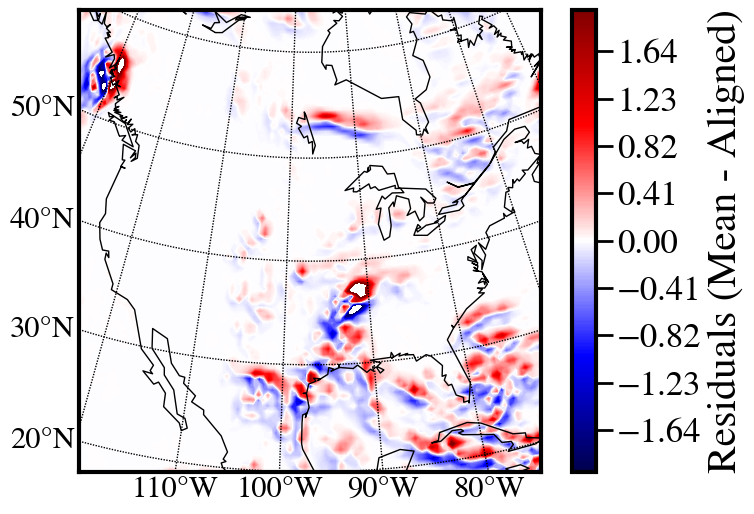

In [9]:
resid_range = np.arange(-2, 2.01, 0.01)
lats, lons = gefs_data.latitude.data, gefs_data.longitude.data
m = Basemap(projection='lcc',lon_0=-97,lat_0=42,width=5e6,height=5e6,resolution='c')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
cs = m.contourf(xx,yy,raw_mean - np.mean(full_ens_stitched, axis=0) ,levels=resid_range,cmap=plt.cm.seismic)

m.drawcoastlines()
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22)
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22)
plt.colorbar(cs, label='Residuals (Mean - Aligned)')

In [10]:
def find_nearest(array,value):
    idx = (np.abs(np.array(array)-value)).argmin()
    return idx

/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/tmp/ipykernel_45350/2395901600.py:31: RuntimeWarning: divide by zero encountered in log10
  cs = m.contourf(xx,yy,np.log10(np.std(full_ens_stitched,axis=0)),levels=temp_range,cmap=plt.cm.jet,ax=axes[1],)


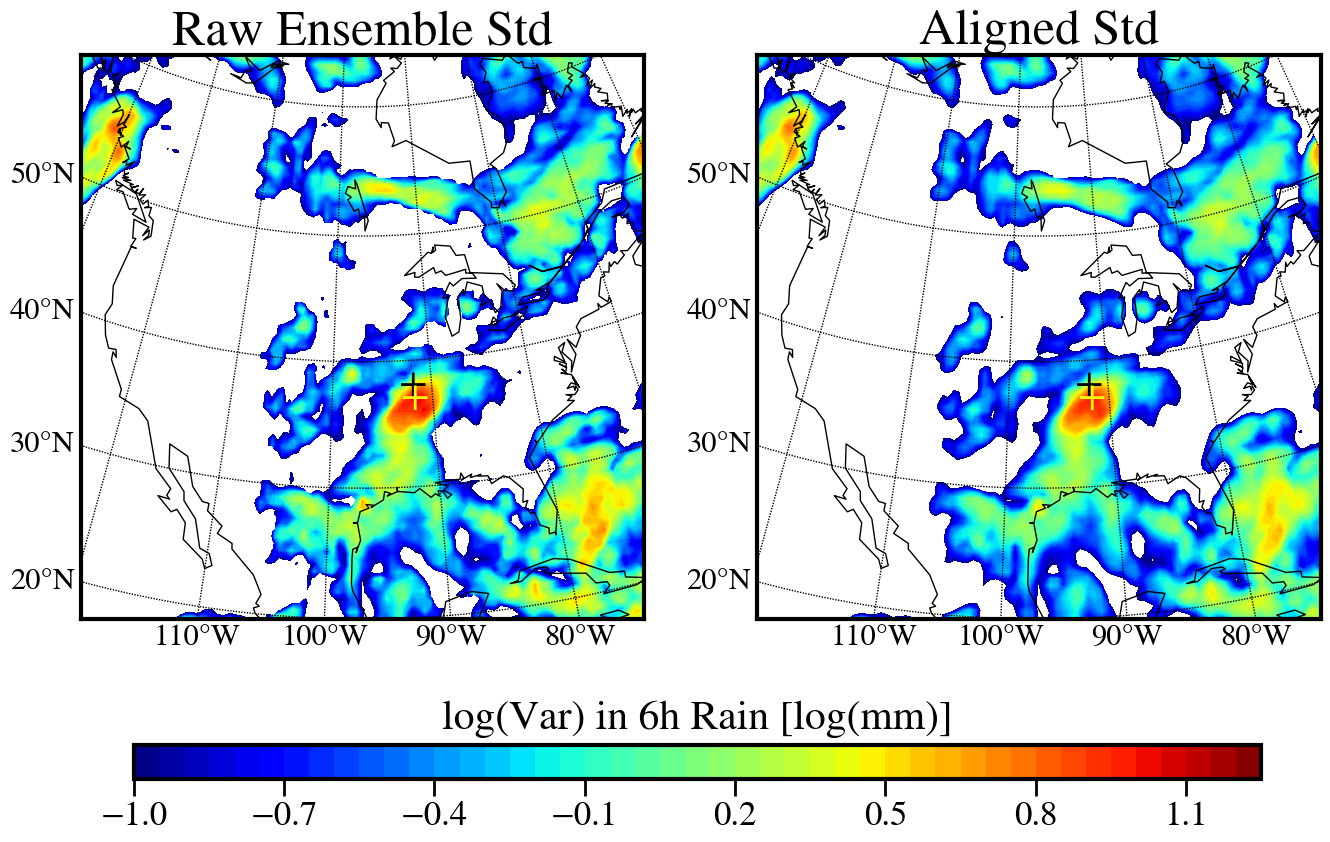

In [11]:
fig, axes = plt.subplots(1,2, figsize=(16,12), sharey=True)
temp_range = np.arange(-1,1.3,0.05)

#GEFS
lats, lons = gefs_data.latitude.data, gefs_data.longitude.data
m = Basemap(projection='lcc',lon_0=-97,lat_0=42,width=5e6,height=5e6,resolution='c')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
cs = m.contourf(xx,yy,np.log10(gefs_data.APCP.std(dim='member')),levels=temp_range,cmap=plt.cm.jet,ax=axes[0])
axes[0].set_title('Raw Ensemble Std')
cbar_ax = inset_axes(axes[0],
                    width="200%",  # width = 50% of parent_bbox width
                    height="6%",  # height : 5%
                    loc='upper left',bbox_to_anchor=(0.07, -1.2, 1, 1),bbox_transform=axes[0].transAxes)

cbar=plt.colorbar(cs,orientation='horizontal', cax=cbar_ax,ticks=np.arange(-1,1.3,0.3))
#cbar.ax.set_xticklabels(['0','2','4', '6', '8', '10','12','14','16','18','20']) 
cbar.set_label('log(Var) in 6h Rain [log(mm)]', labelpad=-95)

#x, y = m(-93, 37)

#m.plot(x, y, color='black', marker='+',latlon=True, ax=axes[0])
x, y = m(-93.347, 37.306)
axes[0].annotate('+', xy=(x,y), color='black')
axes[1].annotate('+', xy=(x,y), color='black')

x, y = m(-93.159, 36.27)
axes[0].annotate('+', xy=(x,y), color='yellow')
axes[1].annotate('+', xy=(x,y), color='yellow')

axes[1].set_title(f'Aligned Std')
cs = m.contourf(xx,yy,np.log10(np.std(full_ens_stitched,axis=0)),levels=temp_range,cmap=plt.cm.jet,ax=axes[1],)

for ax in range(2):
    m.drawcoastlines(ax=axes[ax])
    m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes[ax])
    m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes[ax])


In [12]:
#--------------------------------#
# Spread at key storm area
#--------------------------------#
#add back to GEFS dataset
members=np.arange(0,21)
aligned_ens_xr = xr.DataArray(full_ens_stitched, 
coords={'member': members,'latitude': gefs_data.latitude,'longitude': gefs_data.longitude}, 
dims=["member","y", "x"],attrs=gefs_data.APCP.attrs)
gefs_data['Aligned_APCP'] = aligned_ens_xr

gefs_ksgf = gefs_data.grib2io.interp_to_stations('bilinear', ['KSGF'], [37.306], [-93.347])
gefs_khro = gefs_data.grib2io.interp_to_stations('bilinear', ['KSGF'], [36.27], [-93.159])


In [81]:
springfield = scipy.stats.gamma(*scipy.stats.gamma.fit(gefs_ksgf.APCP.data.compute()))

Text(0.5, 1.0, 'KHRO')

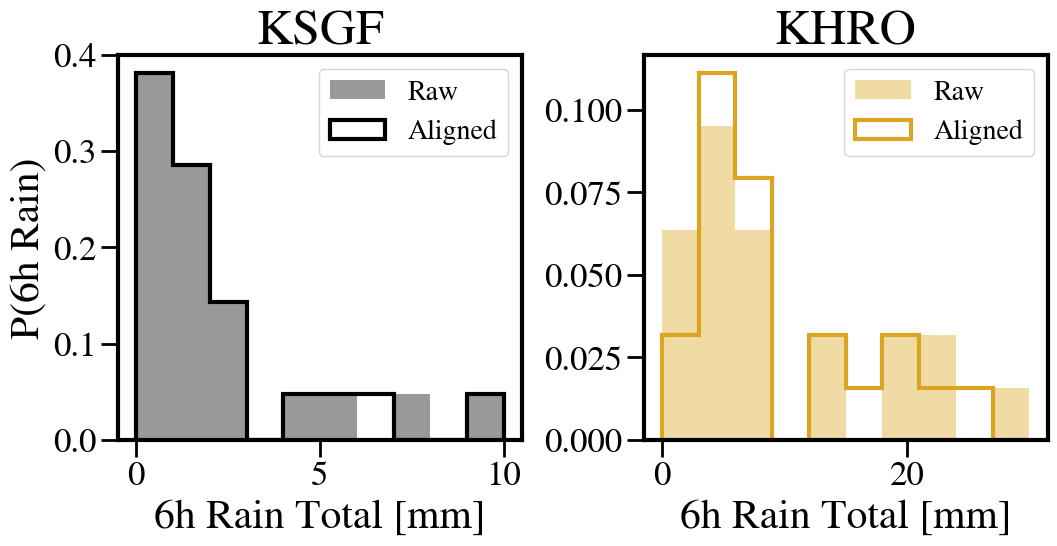

In [18]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
plt.subplots_adjust(wspace=0.3)

springfield = scipy.stats.gamma(*scipy.stats.gamma.fit(gefs_ksgf.APCP.data.compute()))
axes[0].hist(gefs_ksgf.APCP.data.compute(),color='black',range=(0,10),bins=10, alpha=0.4, label='Raw',density=True)
axes[0].hist(gefs_ksgf.Aligned_APCP.data.compute(),range=(0,10),bins=10,color='black', histtype='step',lw=3, label='Aligned',density=True)
xrange = np.linspace(0,30,200)
#axes[0].plot(xrange, springfield.pdf(xrange), color='black', lw=3,ls=':')

hro = scipy.stats.gamma(*scipy.stats.gamma.fit(gefs_khro.APCP.data.compute()))
axes[1].hist(gefs_khro.APCP.data.compute(),range=(0,30),bins=10,color='goldenrod', alpha=0.4,label='Raw',density=True)
axes[1].hist(gefs_khro.Aligned_APCP.data.compute(),range=(0,30),bins=10,color='goldenrod', histtype='step',lw=3, label='Aligned',density=True)
xrange = np.linspace(0,30,200)
#axes[1].plot(xrange, hro.pdf(xrange), color='goldenrod', lw=3,ls=':')

axes[0].set_ylabel('P(6h Rain)')
axes[0].set_xlabel('6h Rain Total [mm]')
axes[1].set_xlabel('6h Rain Total [mm]')
axes[0].legend()
axes[1].legend()
axes[0].set_title('KSGF')
axes[1].set_title('KHRO')

In [14]:
urma_path='/scratch2/STI/mdl-sti/Sidney.Lower/urma/urma2p5.2021060118.pcp_06h.wexp.grb2'

filters = dict(productDefinitionTemplateNumber=8)
u1 = xr.open_dataset(urma_path,engine='grib2io', filters=filters)

In [15]:
grid_def_out = u1.grib2io.griddef()
gefs_to_urma = gefs_data.grib2io.interp('bilinear', grid_def_out)

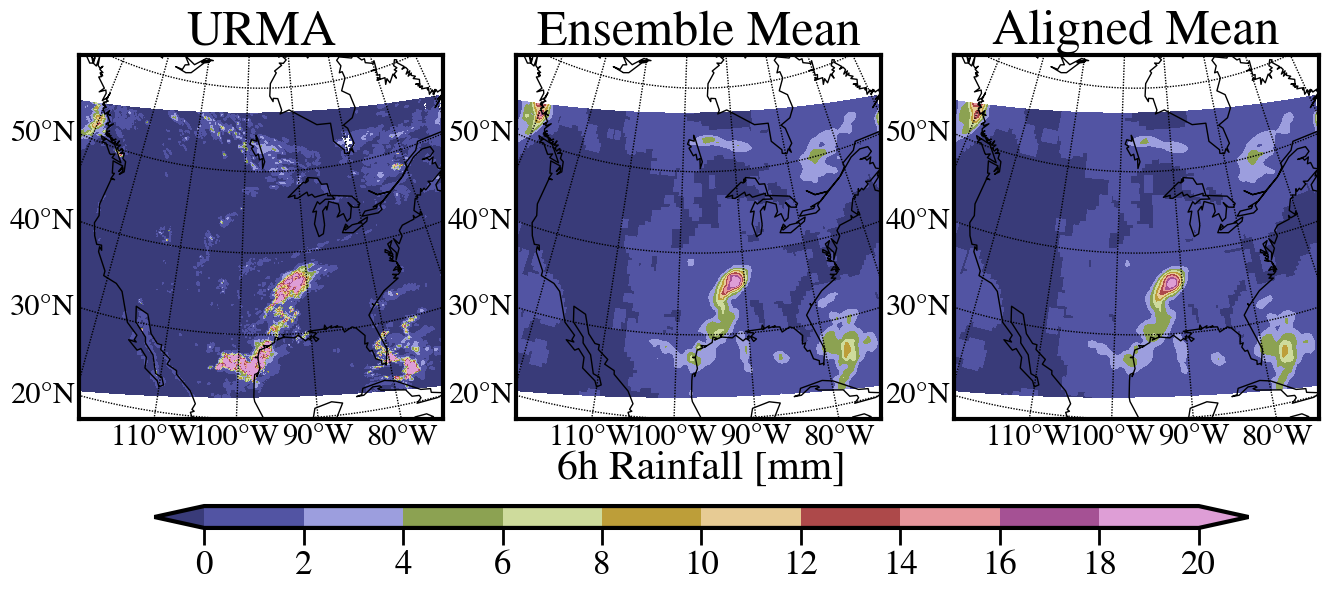

In [17]:
fig, axes = plt.subplots(1,3, figsize=(16,12), sharey=True)
temp_range = np.arange(0,22,2)

#GEFS
lats, lons = u1.latitude.data, u1.longitude.data
m = Basemap(projection='lcc',lon_0=-97,lat_0=42,width=5e6,height=5e6,resolution='c')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
cs = m.contourf(xx,yy,u1.APCP.data,levels=temp_range,cmap=plt.cm.tab20b,extend='both',ax=axes[0])
axes[0].set_title('URMA')
cbar_ax = inset_axes(axes[0],
                    width="300%",  # width = 50% of parent_bbox width
                    height="6%",  # height : 5%
                    loc='upper left',bbox_to_anchor=(0.17, -1.2, 1, 1),bbox_transform=axes[0].transAxes)

cbar=plt.colorbar(cs,orientation='horizontal', cax=cbar_ax,ticks=np.arange(0,22,2))
cbar.ax.set_xticklabels(['0','2','4', '6', '8', '10','12','14','16','18','20']) 
cbar.set_label('6h Rainfall [mm]', labelpad=-95)


axes[1].set_title(f'Ensemble Mean')
m.contourf(xx,yy,gefs_to_urma.APCP.mean(dim='member'),levels=temp_range,cmap=plt.cm.tab20b,extend='both',ax=axes[1],)

axes[2].set_title(f'Aligned Mean')
m.contourf(xx,yy,gefs_to_urma.Aligned_APCP.mean(dim='member'),levels=temp_range,cmap=plt.cm.tab20b,extend='both',ax=axes[2],)

for ax in range(3):
    m.drawcoastlines(ax=axes[ax])
    m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes[ax])
    m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes[ax])


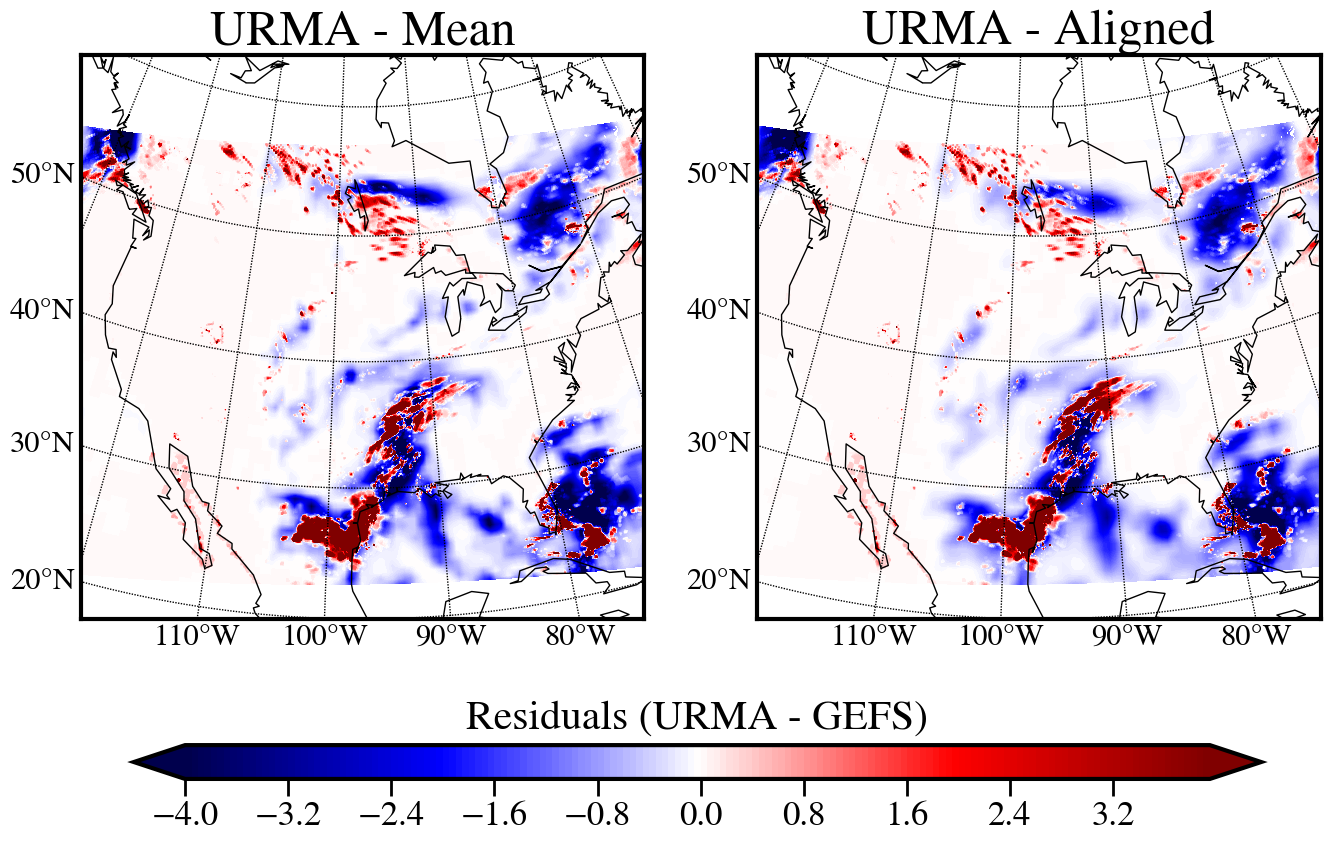

In [98]:
fig, axes = plt.subplots(1,2, figsize=(16,12), sharey=True)
temp_range = np.arange(-4,4,0.05)

#GEFS
lats, lons = u1.latitude.data, u1.longitude.data
m = Basemap(projection='lcc',lon_0=-97,lat_0=42,width=5e6,height=5e6,resolution='c')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
cs = m.contourf(xx,yy,u1.APCP.data-gefs_to_urma.APCP.mean(dim='member'),levels=temp_range,cmap=plt.cm.seismic,extend='both',ax=axes[0])
axes[0].set_title('URMA - Mean')
cbar_ax = inset_axes(axes[0],
                    width="200%",  # width = 50% of parent_bbox width
                    height="6%",  # height : 5%
                    loc='upper left',bbox_to_anchor=(0.07, -1.2, 1, 1),bbox_transform=axes[0].transAxes)

cbar=plt.colorbar(cs,orientation='horizontal', cax=cbar_ax)
#cbar.ax.set_xticklabels(['0','2','4', '6', '8', '10','12','14','16','18','20']) 
cbar.set_label('Residuals (URMA - GEFS)', labelpad=-95)


axes[1].set_title(f'URMA - Aligned')
cs = m.contourf(xx,yy,u1.APCP.data-gefs_to_urma.Aligned_APCP.mean(dim='member'),levels=temp_range,cmap=plt.cm.seismic,extend='both',ax=axes[1],)


for ax in range(2):
    m.drawcoastlines(ax=axes[ax])
    m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes[ax])
    m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes[ax])


## Distortion Field

In [32]:

ens_mean = gefs_data.APCP.mean(dim='member')
raw_mean = ens_mean.data.compute()
ens_members = gefs_data.APCP.data.compute()
ens_std = gefs_data.APCP.std(dim='member').data.compute()

min_lon = 240 
max_lon = 601
min_lat = 0
max_lat = 361

m_k, n_k = basis_truncation(5)
y = gefs_data.latitude.data.compute().T[0][min_lat:max_lat]
x = gefs_data.longitude.data[0].compute()[min_lon:max_lon]
#get displacement basis functions, transforms grid x,y to fourier space
b_ik = basis_functions(x, y, m_k, n_k, [x[0], x[-1]], [y[0], y[-1]])
d_o_f = len(m_k)
xy_list = np.reshape([x,y],  (2,-1),order='C').T

full_ens_stitched = np.zeros_like(ens_members)

std = 1.3
S_a = 0.5
S_mag = 0.5

bounds = [[-1.,1.]]*np.shape(b_ik)[1]*2

for mem in [9]:
    ens_mem = ens_members[mem,min_lat:max_lat,min_lon:max_lon].T
    interp = RegularGridInterpolator((x,y), ens_mem,bounds_error=False, fill_value=None)
    c_k = {"x": np.repeat(0.1, d_o_f), "y": np.repeat(0.1, d_o_f)}
    ck_arr = np.ravel(np.array([c_k['x'], c_k['y']])) 
    minimize = scipy.optimize.minimize(fun=get_j,x0=ck_arr ,jac='2-point', 
                                       args=(b_ik, raw_mean[min_lat:max_lat,min_lon:max_lon].T, 
                                            std, S_a,S_mag,interp,xy_list, m_k, n_k), method='L-BFGS-B',bounds=bounds,
                                      options={'disp':True, 'iprint': 100,'maxfun': 15000, 'finite_diff_rel_step': 1.})
    c_k_minimized = {"x": minimize.x[:np.shape(b_ik)[1]], "y": minimize.x[np.shape(b_ik)[1]:]}
    c_xi = np.dot(b_ik, c_k_minimized['x'])
    c_yi = np.dot(b_ik, c_k_minimized['y'])
    n_x_i = x + c_xi
    n_y_i = y + c_yi
    
    xy_grid = np.meshgrid(n_x_i,n_y_i ,indexing='ij')
    displaced_grid = np.reshape(xy_grid, (2, -1), order='C').T
    displaced_precip = interp(displaced_grid)
    
    displaced_ens = np.zeros_like(raw_mean)
    for i in range(len(c_xi)):
        for j in range(len(c_yi)):
            point = len(c_yi)*i+j
            #print(point)
            displaced_ens[j+min_lat, i+min_lon] = displaced_precip[point]
            
    full_ens_stitched[mem,:,:] = displaced_ens

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46936D+01    |proj g|=  1.10000D+00

At iterate    1    f=  5.81191D+00    |proj g|=  1.63544D-01

At iterate    2    f=  5.80918D+00    |proj g|=  9.23683D-02

At iterate    3    f=  5.80595D+00    |proj g|=  3.33205D-02

At iterate    4    f=  5.80505D+00    |proj g|=  1.78214D-02

At iterate    5    f=  5.80456D+00    |proj g|=  2.31179D-02

At iterate    6    f=  5.80448D+00    |proj g|=  1.15509D-02

At iterate    7    f=  5.80446D+00    |proj g|=  9.41523D-03

At iterate    8    f=  5.80445D+00    |proj g|=  9.11537D-03

At iterate    9    f=  5.80438D+00    |proj g|=  5.99187D-03

At iterate   10    f=  5.80432D+00    |proj g|=  2.83177D-03

At iterate   11    f=  5.80431D+00    |proj g|=  1.09791D-03

At iterate   12    f=  5.80430D+00    |proj g|=  1.50055D-04

At iterate   13    f=  5.8

In [41]:
xy_displacements = np.meshgrid(c_xi, c_yi, indexing='ij')
displaced_grid = np.reshape(xy_displacements, (2, -1), order='C').T

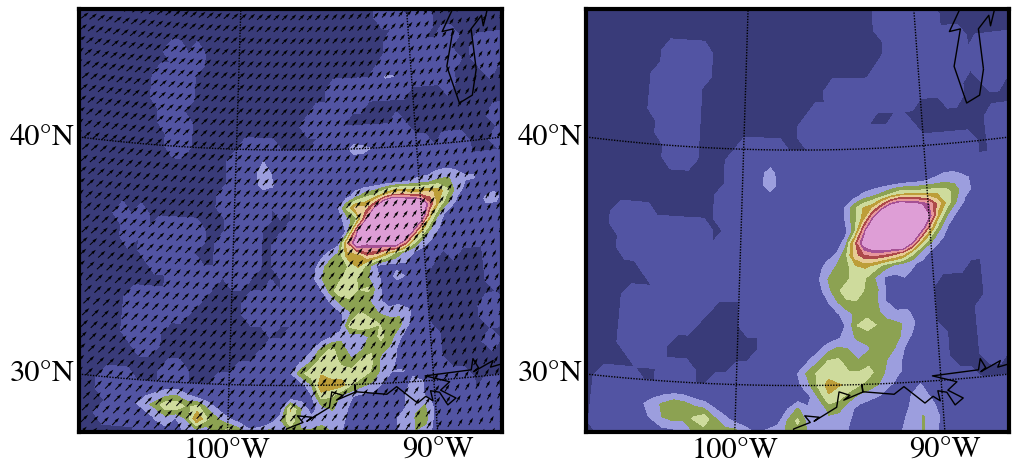

In [53]:
temp_range = np.arange(0,22,2)
fig, axes=plt.subplots(1,2, figsize=(12,8))
y = gefs_data.latitude.data.compute().T[0][min_lat:max_lat]
x = gefs_data.longitude.data[0].compute()[min_lon:max_lon]
lats, lons = np.meshgrid(y,x)
m = Basemap(projection='lcc',lon_0=-97,lat_0=37,width=2e6,height=2e6,resolution='c')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
cs = m.contourf(xx,yy,ens_mem ,levels=temp_range,cmap=plt.cm.tab20b,extend='both',ax=axes[0])

for i in range(2):
    m.drawcoastlines(ax=axes[i])
    m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes[i])
    m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes[i])

m.quiver(xx, yy, displaced_grid[:,0], displaced_grid[:,1],angles='xy', scale_units='xy', scale=0.000006, ax=axes[0])

m.contourf(xx,yy,displaced_ens[min_lat:max_lat, min_lon:max_lon].T ,levels=temp_range,cmap=plt.cm.tab20b,extend='both',ax=axes[1])

## Things to think about

The above is a simplistic walkthrough of coalescence as a means to (physically meaningfully) get info from an ensemble of forecasts while being mindful of the characteristics of the distribution of precipitation and coherent structure predictions. The hope for such an algorithm is to act as a pre-process for the QMD routine in the blend, in which the position aligned ensemble mean will be compared to the quantiles of the analysis, allowing QMD to correct for the amplitude/additive errors. 

As evidenced by this code and Nehrkorn, Hamill, and Henderson (in prep), the assumptions (implicit and explicit) involved in this process are numerous and not so transparent. Considerations must be taken with regards to the tuned parameters (scales, penalty function weights, spectral space truncation, etc.) and how they may impact the results. 

I also have not taken any steps to validate the results of this algorithm, aside from confirming the minimization returns a result that *by eye* is reasonable. Future work will be done to statistically validate the alignment results and explore the parameter space and its impact on the results. 

## Testing: when does each penalty function dominate? scoping out penalty function weights, scalings, truncation, etc.

In [112]:
def get_j(ck_arr, b_ik, mean, obs_error, S,S_mag,interp_object,grid_points, m_k, n_k):
    c_k = {"x": ck_arr[:np.shape(b_ik)[1]], "y": ck_arr[np.shape(b_ik)[1]:]}
    j_r = residual_error(c_k, b_ik, mean,obs_error, interp_object,grid_points)
    j_a = barrier_func_gp(c_k, b_ik, S)
    j_d = smoothness_func_spec(c_k, m_k, n_k)
    j_div = divergence_func_gp(c_k, b_ik)
    j_m = magnitude_func_spec(c_k, S_mag)

    lambda_spec = np.shape(mean)[0]**2 / len(m_k)

    print(f'Jr = {j_r:.2e}')
    print(f'Ja = {j_a:.2e}')
    print(f'Jd = {1720*j_d:.2e}')
    print(f'Jm = {1720*j_m:.2e}')
    print(f'Jdiv = {j_div:.2e}')
    
    return j_r + j_a + lambda_spec*j_d + lambda_spec*j_m + j_div


ens_mean = gefs_data.APCP.mean(dim='member')
raw_mean = ens_mean.data.compute()
ens_members = gefs_data.APCP.data.compute()
ens_std = gefs_data.APCP.std(dim='member').data.compute()
min_lon = 240 
max_lon = 601
min_lat = 0
max_lat = 361

#get displacement basis functions, transforms grid x,y to fourier space
m_k, n_k = basis_truncation(5)
y = gefs_data.latitude.data.compute().T[0][min_lat:max_lat]
x = gefs_data.longitude.data[0].compute()[min_lon:max_lon]
b_ik = basis_functions(x, y, m_k, n_k, [x[0], x[-1]], [y[0], y[-1]])
d_o_f = len(m_k)
xy_list = np.reshape([x,y],  (2,-1),order='C').T

#set error, scalings
#std = ens_std.copy()[min_lat:max_lat,min_lon:max_lon].T
#r, c = np.where(std == 0.0)
#std[r, c] = 1e-1
std=0.5
S_a = 1.5
S_mag = 0.1

mem=10
ens_mem = ens_members[mem,min_lat:max_lat,min_lon:max_lon].T
interp = RegularGridInterpolator((x,y), ens_mem,bounds_error=False, fill_value=None)

ckx, cky = 0.1,0.1
c_k = {"x": np.repeat(ckx, d_o_f), "y": np.repeat(cky, d_o_f)}
ck_arr = np.ravel(np.array([c_k['x'], c_k['y']])) 
obj = get_j(ck_arr, b_ik, raw_mean[min_lat:max_lat,min_lon:max_lon].T, 
                                                std, S_a,S_mag,interp,xy_list, m_k, n_k)

Jr = 4.03e+06
Ja = 1.42e+05
Jd = 2.70e+05
Jm = 5.16e+04
Jdiv = 0.00e+00


## Testing: Objective function and gradient

In [ ]:
mem=10
xrange,yrange,num=0.2,0.2,20
m_k, n_k = basis_truncation(7)
y = gefs_data.latitude.data.compute().T[0][min_lat:max_lat]
x = gefs_data.longitude.data[0].compute()[min_lon:max_lon]
#get displacement basis functions, transforms grid x,y to fourier space
b_ik = basis_functions(x, y, m_k, n_k, [x[0], x[-1]], [y[0], y[-1]])
d_o_f = len(m_k)
xy_list = np.reshape([x,y],  (2,-1),order='C').T

std=0.36
S_a = 1.5
S_mag = 0.1

jval=np.empty((num,num))
ens_mem = ens_members[mem,min_lat:max_lat,min_lon:max_lon].T
interp = RegularGridInterpolator((x,y), ens_mem,bounds_error=False, fill_value=None)
for ckx,xidx in tqdm(zip(np.linspace(xrange*-1, xrange,num), np.arange(num)), total=num):
    for cky,yidx in zip(np.linspace(yrange*-1, yrange,num), np.arange(num)):
        c_k = {"x": np.repeat(ckx, d_o_f), "y": np.repeat(cky, d_o_f)}
        ck_arr = np.ravel(np.array([c_k['x'], c_k['y']])) 
        obj = get_j(ck_arr, b_ik, raw_mean[min_lat:max_lat,min_lon:max_lon].T, 
                                                std, S_a,S_mag,interp,xy_list, m_k, n_k)
        jval[xidx,yidx] = obj

In [ ]:
X,Y=np.meshgrid(np.linspace(xrange*-1,xrange,num),np.linspace(yrange*-1, yrange,num))

cs=plt.contourf(X,Y,np.log10(jval))#,levels=np.linspace(6.58,11,100))
plt.colorbar(label='log(J)')
plt.xlabel('$\Delta x$')
plt.ylabel('$\Delta y$')


## Testing: what minimization+gradient routine? and how to better constrain the variables

In [ ]:
#setup displacements
m_k, n_k = basis_truncation(7)
y = gefs_data.latitude.data.compute().T[0][min_lat:max_lat]
x = gefs_data.longitude.data[0].compute()[min_lon:max_lon]
#get displacement basis functions, transforms grid x,y to fourier space
b_ik = basis_functions(x, y, m_k, n_k, [x[0], x[-1]], [y[0], y[-1]])
d_o_f = len(m_k)
xy_list = np.reshape([x,y],  (2,-1),order='C').T

full_ens_stitched = np.zeros_like(ens_members)

c_kx_minimize, c_ky_minimize = [],[]

#align_to = ens_members[10,min_lat:max_lat,min_lon:max_lon]

#std = ens_std.copy()[min_lat:max_lat,min_lon:max_lon].T
#r, c = np.where(std == 0.0)
#std[r, c] = 0.05
std = 1.3
S_a = 0.7
S_mag = 0.2

bounds = [[-1.,1.]]*np.shape(b_ik)[1]*2

for mem in tqdm(range(21)):
    ens_mem = ens_members[mem,min_lat:max_lat,min_lon:max_lon].T
    interp = RegularGridInterpolator((x,y), ens_mem,bounds_error=False, fill_value=None)
    c_k = {"x": np.repeat(0.1, d_o_f), "y": np.repeat(0.1, d_o_f)}
    ck_arr = np.ravel(np.array([c_k['x'], c_k['y']])) 
    minimize = scipy.optimize.minimize(fun=get_j,x0=ck_arr ,jac=None,#jac=get_gradient_j, 
                                       args=(b_ik, raw_mean[min_lat:max_lat,min_lon:max_lon].T, 
                                            std, S_a,S_mag,interp,xy_list, m_k, n_k), method='TNC',
                                      options={'disp': True, 'ftol': 100.},bounds=bounds)
    #scipy.optimize.fmin_l_bfgs_b(func=get_j, x0=ck_arr, fprime=None, args=(b_ik, raw_mean[min_lat:max_lat,min_lon:max_lon].T, 
    #                                        std, S_a,S_mag,interp,xy_list, m_k, n_k), factr=1000.,
    #                             approx_grad=True, bounds=bounds, epsilon=1e-12, iprint=100)
    c_k_minimized = {"x": minimize.x[:np.shape(b_ik)[1]], "y": minimize.x[np.shape(b_ik)[1]:]}
    #c_kx_minimize.append(minimize.x[:np.shape(b_ik)[1]])
    #c_ky_minimize.append(minimize.x[np.shape(b_ik)[1]:])
    c_xi = np.dot(b_ik, c_k_minimized['x'])
    c_yi = np.dot(b_ik, c_k_minimized['y'])
    n_x_i = x + c_xi
    n_y_i = y + c_yi
    
    xy_grid = np.meshgrid(n_x_i,n_y_i ,indexing='ij')
    displaced_grid = np.reshape(xy_grid, (2, -1), order='C').T
    displaced_precip = interp(displaced_grid)
    
    displaced_ens = np.zeros_like(raw_mean)
    for i in range(len(c_xi)):
        for j in range(len(c_yi)):
            point = len(c_yi)*i+j
            #print(point)
            displaced_ens[j+min_lat, i+min_lon] = displaced_precip[point]
            
    full_ens_stitched[mem,:,:] = displaced_ens

# Scikit optimize

In [4]:
from scipy.interpolate import RegularGridInterpolator

#objective function
def get_j(ck_arr, b_ik, mean, obs_error, S,S_mag,interp_object,grid_points, m_k, n_k):
    c_k = {"x": ck_arr[:np.shape(b_ik)[1]], "y": ck_arr[np.shape(b_ik)[1]:]}
    j_r = residual_error(c_k, b_ik, mean,obs_error, interp_object,grid_points)
    j_a = barrier_func_gp(c_k, b_ik, S)
    j_d = smoothness_func_spec(c_k, m_k, n_k)
    j_div = divergence_func_gp(c_k, b_ik)
    j_m = magnitude_func_spec(c_k, S_mag)

    lambda_spec = np.shape(mean)[0]**2 / len(m_k)

    return j_r + j_a + lambda_spec*j_d + lambda_spec*j_m + j_div

def residual_error(c_k,b_ik,ens_mean,  obs_error, interp_object,grid_points):
    
    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])
    
    n_x_i = grid_points[:,0] + c_xi
    n_y_i = grid_points[:,1] + c_yi
    xy_grid = np.meshgrid(n_x_i,n_y_i, indexing='ij')
    displaced_grid = np.reshape(xy_grid, (2, -1), order='C').T
    displaced_precip = interp_object(displaced_grid)

    displaced_ens = np.zeros_like(ens_mean)
    for i in range(len(c_xi)):
        for j in range(len(c_yi)):
            point = len(c_yi)*i+j
            #print(point)
            displaced_ens[j, i] = displaced_precip[point]
    
    before_sum = (ens_mean - displaced_ens)**2
    return np.sum(before_sum / obs_error**2)

def barrier_func_gp(c_k, b_ik,S): #Ja
    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])
    return np.sum((c_xi / S)**20 +  (c_yi / S)**20)

def smoothness_func_spec(c_k, m_k, n_k): #Jd
    nu_k = (m_k**2 + n_k**2)**(2)
    scale = 0.5
    weight = 1.
    w_k={'x': (weight / scale**2) * nu_k,
            'y': (weight / scale**2) * nu_k}
    return np.sum(w_k['x'] * c_k['x']**2 + w_k['y'] * c_k['y']**2)

def divergence(field):
    "return the divergence of a n-D field"
    return np.sum(np.gradient(field),axis=0)

def divergence_func_gp(c_k, b_ik):

    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])
    nx, ny = len(c_xi), len(c_yi)

    dx = divergence(c_xi)
    dy = divergence(c_yi)
    return (dx+dy)**2

def magnitude_func_spec(c_k, S_mag):
    return np.sum((c_k['x']/S_mag)**2 + (c_k['y']/S_mag)**2)

def basis_functions(target_x, target_y, m_k=None, n_k=None, xrange=(np.nan, np.nan), yrange=(np.nan, np.nan)):

    x = grid2fourier(target_x, xrange)
    y = grid2fourier(target_y, yrange)

    b_ik = np.zeros((len(x), len(m_k)))

    for k in range(len(m_k)):
        b_ik[:, k] = 2 * np.sin(m_k[k] * x) * np.sin(n_k[k] * y)

    return b_ik

def grid2fourier(x, xrange):
    return (np.pi / np.diff(xrange)) * (x - xrange[0])

def basis_truncation(n=3):
    m_k = np.repeat(np.arange(1, n + 1), n)
    n_k = np.repeat(np.arange(1, n + 1), np.repeat(n, n))
    select = m_k**2 + n_k**2 <= n**2

    return m_k[select], n_k[select]

In [5]:
from skopt import gp_minimize

In [6]:
#--------------------------------------#
#
#  Bigger Box
#
#--------------------------------------#
ens_mean = gefs_data.APCP.mean(dim='member')
raw_mean = ens_mean.data.compute()
ens_members = gefs_data.APCP.data.compute()
ens_std = gefs_data.APCP.std(dim='member').data.compute()

min_lon = 240 
max_lon = 601
min_lat = 0
max_lat = 361

In [7]:
#setup displacements
m_k, n_k = basis_truncation(5)
y = gefs_data.latitude.data.compute().T[0][min_lat:max_lat]
x = gefs_data.longitude.data[0].compute()[min_lon:max_lon]
#get displacement basis functions, transforms grid x,y to fourier space
b_ik = basis_functions(x, y, m_k, n_k, [x[0], x[-1]], [y[0], y[-1]])
d_o_f = len(m_k)
xy_list = np.reshape([x,y],  (2,-1),order='C').T

full_ens_stitched = np.zeros_like(ens_members)

std = 1.3
S_a = 0.5
S_mag = 0.5

bounds = [[-1.,1.]]*np.shape(b_ik)[1]*2

In [ ]:
from functools import partial

def optimize_wrapper(X, y):
    X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=.25)
    objective = partial(objective, X_train, y_train)
    res_gp = gp_minimize(objective, space, x0=x0, n_calls=50, random_state=0)

In [ ]:
def objective(params):
    max_depth, learning_rate, max_features, min_samples_split, min_samples_leaf = params

    reg.set_params(max_depth=max_depth,
                   learning_rate=learning_rate,
                   max_features=max_features,
                   min_samples_split=min_samples_split, 
                   min_samples_leaf=min_samples_leaf)

    return -np.mean(cross_val_score(reg, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

def optimize_ml(X, y):
    global X_train
    global y_train
    global reg

    X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=.25)
    reg = GradientBoostingRegressor(n_estimators=50, random_state=0)

    space  = [(1, 5),                           # max_depth
          (10**-5, 10**-1, "log-uniform"),  # learning_rate
          (1, X.shape[1]),                  # max_features
          (2, 30),                          # min_samples_split
          (1, 30)]                          # min_samples_leaf

    x0 = [3, 0.01, 6, 2, 1]
    res_gp = gp_minimize(objective, space, x0=x0, n_calls=50, random_state=0)

In [ ]:
res = gp_minimize(f, [(-2.0, 2.0)], n_calls=20)

In [ ]:
for mem in tqdm(range(21)):
    ens_mem = ens_members[mem,min_lat:max_lat,min_lon:max_lon].T
    interp = RegularGridInterpolator((x,y), ens_mem,bounds_error=False, fill_value=None)
    c_k = {"x": np.repeat(0.1, d_o_f), "y": np.repeat(0.1, d_o_f)}
    ck_arr = np.ravel(np.array([c_k['x'], c_k['y']])) 
    minimize = scipy.optimize.minimize(fun=get_j,x0=ck_arr ,jac=None, 
                                       args=(b_ik, raw_mean[min_lat:max_lat,min_lon:max_lon].T, 
                                            std, S_a,S_mag,interp,xy_list, m_k, n_k), method='SLSQP',bounds=bounds,
                                      options={'disp':True})# 'iprint': 100,'maxfun': 300})
    c_k_minimized = {"x": minimize.x[:np.shape(b_ik)[1]], "y": minimize.x[np.shape(b_ik)[1]:]}
    c_xi = np.dot(b_ik, c_k_minimized['x'])
    c_yi = np.dot(b_ik, c_k_minimized['y'])
    n_x_i = x + c_xi
    n_y_i = y + c_yi
    
    xy_grid = np.meshgrid(n_x_i,n_y_i ,indexing='ij')
    displaced_grid = np.reshape(xy_grid, (2, -1), order='C').T
    displaced_precip = interp(displaced_grid)
    
    displaced_ens = np.zeros_like(raw_mean)
    for i in range(len(c_xi)):
        for j in range(len(c_yi)):
            point = len(c_yi)*i+j
            #print(point)
            displaced_ens[j+min_lat, i+min_lon] = displaced_precip[point]
            
    full_ens_stitched[mem,:,:] = displaced_ens